## SHAP, LRP & Attention Scores with Attention-Based LSTM
**Authors:**<br>
Lin Lee Cheong <br>
Tesfagabir Meharizghi<br>

**Date:**<br>
03/31/2021

This notebook trains attention-based LSTM model based on the given data (synthetic/real). In addition, it also computes the SHAP, LRP and attention weights for each trained model. It also trains a separate LSTM model with self attention if needed. Once the importance scores are computed, it also calculates intersection similarity where it gives a score of similarity between the predicted features and ground truth.

Finally, it visualizes the different feature importance scores and per-observation scores.

Note: 
* LRP is not enabled for LSTM with Self Attention.
* In this notebook, due to the intensive computation, SHAP & LRP are calculated for selected number of val & test examples. If you want to compute for all examples, please use [this ipynb](notebook_lstm_lrp_shap_all_data.ipynb).


In [1]:
#! pip install nb_black
#! pip install shap

In [2]:
%load_ext lab_black

%load_ext autoreload

%autoreload 2

In [3]:
import sys
import os
import json
import time
import torch
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from urllib.parse import urlparse
import tarfile
import pickle
import shutil
import matplotlib.pyplot as plt
import shap
import numpy as np

import deep_id_pytorch

from lstm_models import *
from lstm_lrp_models import *
from lstm_att_models import *
from lstm_self_att_models import *
from lstm_utils import *
import imp_utils

In [4]:
IS_SYNTHETIC = True  # If dataset is synthetic/real
# MODEL_NAME = 'lstm'
MODEL_NAME = "lstm"
ADD_SELF_ATTENTION = True  # Whether to train a separate LSTM with Self-Attention

NROWS = 1e9

TRAIN_MODEL = True
SEQ_LEN = 30
DATA_TYPE = "event"  # event/sequence

TRAIN_DATA_PATH = f"../data/synthetic/sample_dataset/{DATA_TYPE}/{SEQ_LEN}/train.csv"
VALID_DATA_PATH = f"../data/synthetic/sample_dataset/{DATA_TYPE}/{SEQ_LEN}/val.csv"
TEST_DATA_PATH = f"../data/synthetic/sample_dataset/{DATA_TYPE}/{SEQ_LEN}/test.csv"
VOCAB_PATH = f"../data/synthetic/sample_dataset/{DATA_TYPE}/{SEQ_LEN}/vocab.pkl"

MODEL_SAVE_PATH_PATTERN = f"./output/synthetic/{DATA_TYPE}/{SEQ_LEN}/{MODEL_NAME}/model_weights/model_{'{}'}.pkl"
IMP_SAVE_DIR_PATTERN = f"./output/synthetic/{DATA_TYPE}/{SEQ_LEN}/{MODEL_NAME}/importances/{'{}'}_imp_{'{}'}.pkl"  # Feature importance values path for a given dataset split

OUTPUT_RESULTS_PATH = (
    f"./output/synthetic/{DATA_TYPE}/{SEQ_LEN}/{MODEL_NAME}/train_results/results.csv"
)
PARAMS_PATH = f"./output/synthetic/{DATA_TYPE}/{SEQ_LEN}/{MODEL_NAME}/train_results/model_params.json"


# Test Patients for Visualization (from Test Set)
SELECTED_PATIENTS = ["VHCSIEPRI8", "MIP0F9ZOUM", "79A4PHXNE6", "CW780GL0AX"]

N_EPOCHS = 10
EARLY_STOPPING_NUM = 2  # For early stopping

TARGET_COLNAME = "label"
UID_COLNAME = "patient_id"
TARGET_VALUE = "1"

# Model Parameters
MODEL_PARAMS = {
    # Dataset/vocab related
    "min_freq": 1,
    "batch_size": 128,
    "num_eval_val": 200,
    "num_eval_test": 200,
    # Model related parameters
    "embedding_dim": 16,
    "hidden_dim": 16,
    "nlayers": 1,
    "bidirectional": True,
    "dropout": 0.3,
    "linear_bias": False,
    "init_type": "zero",  # zero/learned
    "learning_rate": 0.01,
    "scheduler_step": 3,
    "clip": False,
    "rev": False,
    # SHAP-related parameters
    "n_background": 300,  # Number of background examples
    "background_negative_only": True,  # If negative examples are used as background
    "background_positive_only": False,
    "test_positive_only": False,
    "is_test_random": False,
}

In [5]:
# Create output directories if needed
model_dir = os.path.dirname(MODEL_SAVE_PATH_PATTERN)
imp_dir = os.path.dirname(IMP_SAVE_DIR_PATTERN)
output_dir = os.path.dirname(OUTPUT_RESULTS_PATH)
if TRAIN_MODEL:
    if os.path.exists(model_dir):
        shutil.rmtree(model_dir)
    if os.path.exists(imp_dir):
        shutil.rmtree(imp_dir)
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(model_dir)
    os.makedirs(imp_dir)
    os.makedirs(output_dir)
    print(f"Directory Created: {model_dir}")
    print(f"Directory Created: {imp_dir}")
    print(f"Directory Created: {output_dir}")

Directory Created: ./output/synthetic/event/30/lstm/model_weights
Directory Created: ./output/synthetic/event/30/lstm/importances
Directory Created: ./output/synthetic/event/30/lstm/train_results


In [6]:
# Check if cuda is available
print(f"Cuda available: {torch.cuda.is_available()}")
model_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Cuda available: True


In [7]:
# Prepare Selected Patients for SHAP visualization
selected_patients_path = os.path.join(output_dir, "selected_test_patients.csv")
if TRAIN_MODEL:
    # create the test examples set
    test_df = pd.read_csv(TEST_DATA_PATH)
    test_df[test_df.patient_id.isin(SELECTED_PATIENTS)].to_csv(
        selected_patients_path, index=False
    )

## 1. Define and create Dataloaders

In [8]:
train_dataset, vocab = build_lstm_dataset(
    TRAIN_DATA_PATH,
    min_freq=MODEL_PARAMS["min_freq"],
    uid_colname=UID_COLNAME,
    target_colname=TARGET_COLNAME,
    max_len=SEQ_LEN,
    target_value=TARGET_VALUE,
    vocab=None,
    nrows=NROWS,
    rev=MODEL_PARAMS["rev"],
    is_synthetic=IS_SYNTHETIC,
)

valid_dataset, _ = build_lstm_dataset(
    VALID_DATA_PATH,
    min_freq=MODEL_PARAMS["min_freq"],
    uid_colname=UID_COLNAME,
    target_colname=TARGET_COLNAME,
    max_len=SEQ_LEN,
    target_value=TARGET_VALUE,
    vocab=vocab,
    nrows=NROWS,
    rev=MODEL_PARAMS["rev"],
    is_synthetic=IS_SYNTHETIC,
)

test_dataset, _ = build_lstm_dataset(
    TEST_DATA_PATH,
    min_freq=MODEL_PARAMS["min_freq"],
    uid_colname=UID_COLNAME,
    target_colname=TARGET_COLNAME,
    max_len=SEQ_LEN,
    target_value=TARGET_VALUE,
    vocab=vocab,
    nrows=NROWS,
    rev=MODEL_PARAMS["rev"],
    is_synthetic=IS_SYNTHETIC,
)

example_dataset, _ = build_lstm_dataset(
    selected_patients_path,
    min_freq=MODEL_PARAMS["min_freq"],
    uid_colname=UID_COLNAME,
    target_colname=TARGET_COLNAME,
    max_len=SEQ_LEN,
    target_value=TARGET_VALUE,
    vocab=vocab,
    nrows=NROWS,
    rev=MODEL_PARAMS["rev"],
    is_synthetic=IS_SYNTHETIC,
)

Building dataset from ../data/synthetic/sample_dataset/event/30/train.csv..
Success!
Building dataset from ../data/synthetic/sample_dataset/event/30/val.csv..
Success!
Building dataset from ../data/synthetic/sample_dataset/event/30/test.csv..
Success!
Building dataset from ./output/synthetic/event/30/lstm/train_results/selected_test_patients.csv..
Success!


In [9]:
len(vocab._vocab)

47

In [10]:
train_dataloader = DataLoader(
    train_dataset, batch_size=MODEL_PARAMS["batch_size"], shuffle=True, num_workers=2
)

valid_dataloader = DataLoader(
    valid_dataset, batch_size=MODEL_PARAMS["batch_size"], shuffle=False, num_workers=2
)

test_dataloader = DataLoader(
    test_dataset, batch_size=MODEL_PARAMS["batch_size"], shuffle=False, num_workers=2
)

example_dataloader = DataLoader(
    example_dataset, batch_size=MODEL_PARAMS["batch_size"], shuffle=False, num_workers=2
)

In [11]:
if TRAIN_MODEL:
    # Save vocab
    with open(VOCAB_PATH, "wb") as fp:
        pickle.dump(vocab, fp)
    print(f"Dataset Vocabulary Saved to {VOCAB_PATH}")

Dataset Vocabulary Saved to ../data/synthetic/sample_dataset/event/30/vocab.pkl


## LSTM Model Training

### Define and load LRP LSTM model

In [12]:
if not TRAIN_MODEL:
    # LOAD Model Parameters
    with open(PARAMS_PATH, "r") as fp:
        MODEL_PARAMS = json.load(fp)

lstm_model = AttNoHtLSTM(
    MODEL_PARAMS["embedding_dim"],
    MODEL_PARAMS["hidden_dim"],
    vocab,
    model_device,
    bidi=MODEL_PARAMS["bidirectional"],
    nlayers=MODEL_PARAMS["nlayers"],
    dropout=MODEL_PARAMS["dropout"],
    init_type=MODEL_PARAMS["init_type"],
    linear_bias=MODEL_PARAMS["linear_bias"],
)

if ADD_SELF_ATTENTION:
    lstm_model_self = SelfAttentionLSTM(
        MODEL_PARAMS["embedding_dim"],
        MODEL_PARAMS["hidden_dim"],
        vocab,
        model_device,
        bidi=MODEL_PARAMS["bidirectional"],
        nlayers=MODEL_PARAMS["nlayers"],
        dropout=MODEL_PARAMS["dropout"],
        init_type=MODEL_PARAMS["init_type"],
        linear_bias=MODEL_PARAMS["linear_bias"],
    )

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1


In [13]:
lstm_model

AttNoHtLSTM(
  (emb_layer): Embedding(47, 16, padding_idx=0)
  (lstm): LSTM(16, 16, batch_first=True, dropout=0.3, bidirectional=True)
  (pred_layer): Linear(in_features=32, out_features=1, bias=False)
  (dpt): Dropout(p=0.3, inplace=False)
)

In [14]:
#lstm_model_self

SelfAttentionLSTM(
  (emb_layer): Embedding(47, 16, padding_idx=0)
  (lstm): LSTM(16, 16, batch_first=True, dropout=0.3, bidirectional=True)
  (pred_layer): Linear(in_features=32, out_features=1, bias=False)
  (self_att): Attn(
    (main): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (dpt): Dropout(p=0.3, inplace=False)
)

In [15]:
lstm_model.device

device(type='cuda', index=0)

### Train LSTM model

In [16]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(
    lstm_model.parameters(), lr=MODEL_PARAMS["learning_rate"], weight_decay=0.03
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, MODEL_PARAMS["scheduler_step"], gamma=0.9
)

In [17]:
lstm_model = lstm_model.to(model_device)

if ADD_SELF_ATTENTION:
    lstm_model_self = lstm_model_self.to(model_device)

In [18]:
pd.read_csv(TRAIN_DATA_PATH).shape, pd.read_csv(VALID_DATA_PATH).shape, pd.read_csv(
    TEST_DATA_PATH
).shape, pd.read_csv(selected_patients_path).shape

((21000, 34), (7000, 34), (7000, 34), (4, 34))

In [19]:
n_gpus = torch.cuda.device_count()
multigpu_lst = []
for gpu in range(1, n_gpus):
    multigpu_lst.append(f"cuda:{gpu}")

In [20]:
# Model Training Results - Validation/Test
valid_results = {}
test_results = {}

if TRAIN_MODEL:
    best_valid = float("inf")  # For early stopping
    worse_valid = 0

    # Save Model Parameters
    with open(PARAMS_PATH, "w") as fp:
        json.dump(MODEL_PARAMS, fp)

    train_auc_lst = []
    train_loss_lst = []

    val_auc_lst = []
    val_loss_lst = []
    val_lrp_sim_lst = []
    val_shap_sim_lst = []
    val_lrp_shap_tau_lst = []
    val_att_sim_lst = []

    test_auc_lst = []
    test_loss_lst = []
    test_lrp_sim_lst = []
    test_shap_sim_lst = []
    test_lrp_shap_tau_lst = []
    test_att_sim_lst = []

    if ADD_SELF_ATTENTION:
        val_self_att_sim_lst = []
        test_self_att_sim_lst = []

    val_patient_ids, val_labels, val_idxed_text = imp_utils.get_eval_data(
        valid_dataloader, MODEL_PARAMS["num_eval_val"]
    )
    test_patient_ids, test_labels, test_idxed_text = imp_utils.get_eval_data(
        test_dataloader, MODEL_PARAMS["num_eval_test"]
    )
    # val_patient_ids, val_labels, val_idxed_text = next(iter(valid_dataloader))
    # test_patient_ids, test_labels, test_idxed_text = next(iter(test_dataloader))

    for epoch in range(N_EPOCHS):

        start_time = time.time()

        ######## Train LSTM Model and Compute Loss and Performance (AUC) ##########
        lstm_model.train()
        # model training & perf evaluation
        train_loss, train_auc = epoch_train_lstm(
            lstm_model,
            train_dataloader,
            optimizer,
            loss_function,
            clip=MODEL_PARAMS["clip"],
            device=model_device,
        )
        train_auc_lst.append(train_auc)
        train_loss_lst.append(train_loss)

        valid_loss, valid_auc = epoch_val_lstm(
            lstm_model, valid_dataloader, loss_function, device=model_device
        )
        val_auc_lst.append(valid_auc)
        val_loss_lst.append(valid_loss)

        test_loss, test_auc = epoch_val_lstm(
            lstm_model, test_dataloader, loss_function, device=model_device
        )
        test_auc_lst.append(test_auc)
        test_loss_lst.append(test_loss)

        ############# Train LSTM with Self-Attention and get attention weights if needed ###########
        if ADD_SELF_ATTENTION:
            _ = epoch_train_lstm(
                lstm_model_self,
                train_dataloader,
                optimizer,
                loss_function,
                clip=MODEL_PARAMS["clip"],
                device=model_device,
            )

            # extract self-attention scores (val)
            # val_idxed_text = val_idxed_text.cuda()
            _, val_attns = lstm_model_self(val_idxed_text.cuda(), ret_attn=True)
            val_attns = val_attns.cpu().detach().numpy()

            # extract self-attention scores (test)
            # test_idxed_text = test_idxed_text.cuda()
            _, test_attns = lstm_model_self(test_idxed_text.cuda(), ret_attn=True)
            test_attns = test_attns.cpu().detach().numpy()

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # save model
        save_path = MODEL_SAVE_PATH_PATTERN.format(str(epoch).zfill(2))
        torch.save(lstm_model.state_dict(), save_path)

        scheduler.step()

        ######### Calculate Relevancy (LRP) and SHAP (for VAL & TEST examples) ###########
        lstm_model.eval()
        lrp_model = LSTM_LRP_MultiLayer(lstm_model.cpu())

        # Save valid/test results
        valid_results[epoch] = {}
        test_results[epoch] = {}

        for sel_idx in range(len(val_labels)):
            one_text = [
                int(token.numpy())
                for token in val_idxed_text[sel_idx]
                if int(token.numpy()) != 0
            ]
            lrp_model.set_input(one_text)
            lrp_model.forward_lrp()

            Rx, Rx_rev, _ = lrp_model.lrp(one_text, 0, eps=1e-6, bias_factor=0)
            R_words = np.sum(Rx + Rx_rev, axis=1)

            df = pd.DataFrame()
            df["lrp_scores"] = R_words
            df["idx"] = one_text
            df["seq_idx"] = [x for x in range(len(one_text))]
            df["token"] = [lstm_model.vocab.itos(x) for x in one_text]
            df["att_weights"] = lrp_model.get_attn_values()

            if ADD_SELF_ATTENTION:
                df["self_att_weights"] = val_attns[sel_idx][: len(one_text)]

            if val_patient_ids[sel_idx] not in valid_results[epoch]:
                valid_results[epoch][val_patient_ids[sel_idx]] = {}
            valid_results[epoch][val_patient_ids[sel_idx]] = {}
            valid_results[epoch][val_patient_ids[sel_idx]]["label"] = val_labels[
                sel_idx
            ]
            valid_results[epoch][val_patient_ids[sel_idx]]["pred"] = lrp_model.s[0]
            valid_results[epoch][val_patient_ids[sel_idx]]["imp"] = df.copy()

        for sel_idx in range(len(test_labels)):
            one_text = [
                int(token.numpy())
                for token in test_idxed_text[sel_idx]
                if int(token.numpy()) != 0
            ]
            lrp_model.set_input(one_text)
            lrp_model.forward_lrp()

            Rx, Rx_rev, _ = lrp_model.lrp(one_text, 0, eps=1e-6, bias_factor=0)
            R_words = np.sum(Rx + Rx_rev, axis=1)

            df = pd.DataFrame()
            df["lrp_scores"] = R_words
            df["idx"] = one_text
            df["seq_idx"] = [x for x in range(len(one_text))]
            df["token"] = [lstm_model.vocab.itos(x) for x in one_text]
            df["att_weights"] = lrp_model.get_attn_values()

            if ADD_SELF_ATTENTION:
                df["self_att_weights"] = test_attns[sel_idx][: len(one_text)]

            if test_patient_ids[sel_idx] not in test_results[epoch]:
                test_results[epoch][test_patient_ids[sel_idx]] = {}
            test_results[epoch][test_patient_ids[sel_idx]] = {}
            test_results[epoch][test_patient_ids[sel_idx]]["label"] = test_labels[
                sel_idx
            ]
            test_results[epoch][test_patient_ids[sel_idx]]["pred"] = lrp_model.s[0]
            test_results[epoch][test_patient_ids[sel_idx]]["imp"] = df.copy()

        shap_start_time = time.time()
        
        ######### Compute SHAP either with single GPU or MULTI-GPU ############
        if len(multigpu_lst) <= 1:
            (
                val_features,
                val_scores,
                val_patients,
            ) = imp_utils.get_lstm_features_and_shap_scores(
                lstm_model.cuda(),
                train_dataloader,
                valid_dataloader,
                SEQ_LEN,
                "",
                save_output=False,
                n_background=MODEL_PARAMS["n_background"],
                background_negative_only=MODEL_PARAMS["background_negative_only"],
                n_test=MODEL_PARAMS["n_valid_examples"],
                test_positive_only=MODEL_PARAMS["test_positive_only"],
                is_test_random=MODEL_PARAMS["is_test_random"],
            )

            (
                test_features,
                test_scores,
                test_patients,
            ) = imp_utils.get_lstm_features_and_shap_scores(
                lstm_model.cuda(),
                train_dataloader,
                test_dataloader,
                SEQ_LEN,
                "",
                save_output=False,
                n_background=MODEL_PARAMS["n_background"],
                background_negative_only=MODEL_PARAMS["background_negative_only"],
                n_test=MODEL_PARAMS["n_valid_examples"],
                test_positive_only=MODEL_PARAMS["test_positive_only"],
                is_test_random=MODEL_PARAMS["is_test_random"],
            )
        else:
            (
                val_features,
                val_scores,
                val_patients,
            ) = imp_utils.get_lstm_features_and_shap_scores_mp(
                lstm_model.cpu(),
                train_dataloader,
                (val_patient_ids, val_labels, val_idxed_text),
                SEQ_LEN,
                "",
                save_output=False,
                n_background=MODEL_PARAMS["n_background"],
                background_negative_only=MODEL_PARAMS["background_negative_only"],
                test_positive_only=MODEL_PARAMS["test_positive_only"],
                is_test_random=MODEL_PARAMS["is_test_random"],
                multigpu_lst=multigpu_lst,
            )

            (
                test_features,
                test_scores,
                test_patients,
            ) = imp_utils.get_lstm_features_and_shap_scores_mp(
                lstm_model.cpu(),
                train_dataloader,
                (test_patient_ids, test_labels, test_idxed_text),
                SEQ_LEN,
                "",
                save_output=False,
                n_background=MODEL_PARAMS["n_background"],
                background_negative_only=MODEL_PARAMS["background_negative_only"],
                test_positive_only=MODEL_PARAMS["test_positive_only"],
                is_test_random=MODEL_PARAMS["is_test_random"],
                multigpu_lst=multigpu_lst,
            )

        shap_end_time = time.time()
        shap_mins, shap_secs = epoch_time(shap_start_time, shap_end_time)

        ################### Aggregate Results (VAL & TEST examples) #####################
        for idx, pid in enumerate(val_patients):
            df = valid_results[epoch][pid]["imp"]
            assert len(df) == len(val_scores[idx])
            df["shap_scores"] = val_scores[idx]
            if not ADD_SELF_ATTENTION:
                df = df[
                    [
                        "idx",
                        "seq_idx",
                        "token",
                        "att_weights",
                        "lrp_scores",
                        "shap_scores",
                    ]
                ]
            else:
                df = df[
                    [
                        "idx",
                        "seq_idx",
                        "token",
                        "att_weights",
                        "self_att_weights",
                        "lrp_scores",
                        "shap_scores",
                    ]
                ]
            valid_results[epoch][pid]["imp"] = df.copy()

        for idx, pid in enumerate(test_patients):
            df = test_results[epoch][pid]["imp"]
            assert len(df) == len(test_scores[idx])
            df["shap_scores"] = test_scores[idx]
            if not ADD_SELF_ATTENTION:
                df = df[
                    [
                        "idx",
                        "seq_idx",
                        "token",
                        "att_weights",
                        "lrp_scores",
                        "shap_scores",
                    ]
                ]
            else:
                df = df[
                    [
                        "idx",
                        "seq_idx",
                        "token",
                        "att_weights",
                        "self_att_weights",
                        "lrp_scores",
                        "shap_scores",
                    ]
                ]
            test_results[epoch][pid]["imp"] = df.copy()

        ######### Compute Similarity Scores for the Importance Scores for VAL ########
        epoch_val_lrp_shap_t_corr = []
        #         epoch_val_lrp_shap_rbo = []
        epoch_val_lrp_sim = []
        epoch_val_shap_sim = []
        epoch_val_att_sim = []

        if ADD_SELF_ATTENTION:
            epoch_val_self_att_sim = []
            epoch_test_self_att_sim = []

        for pid in valid_results[epoch].keys():
            imp_df = valid_results[epoch][pid]["imp"]
            imp_df["u_token"] = [
                str(seq) + "_" + str(token)
                for seq, token in zip(imp_df["seq_idx"], imp_df["token"])
            ]
            valid_results[epoch][pid]["lrp_shap_t_corr"] = imp_utils.get_wtau(
                imp_df["lrp_scores"], imp_df["shap_scores"]
            )

            epoch_val_lrp_shap_t_corr.append(
                valid_results[epoch][pid]["lrp_shap_t_corr"]
            )

            # gt similarity
            shap_sim = imp_utils.get_intersection_similarity(
                imp_df.shap_scores, imp_df.token, freedom=0, is_synthetic=IS_SYNTHETIC
            )
            lrp_sim = imp_utils.get_intersection_similarity(
                imp_df.lrp_scores, imp_df.token, freedom=0, is_synthetic=IS_SYNTHETIC
            )
            att_sim = imp_utils.get_intersection_similarity(
                imp_df.att_weights, imp_df.token, freedom=0, is_synthetic=IS_SYNTHETIC
            )
            if shap_sim != -1:
                epoch_val_shap_sim.append(shap_sim)
            if lrp_sim != -1:
                epoch_val_lrp_sim.append(lrp_sim)
            if att_sim != -1:
                epoch_val_att_sim.append(att_sim)

            valid_results[epoch][pid]["lrp_sim"] = lrp_sim
            valid_results[epoch][pid]["shap_sim"] = shap_sim
            valid_results[epoch][pid]["att_sim"] = att_sim

            if ADD_SELF_ATTENTION:
                self_att_sim = imp_utils.get_intersection_similarity(
                    imp_df.self_att_weights,
                    imp_df.token,
                    freedom=0,
                    is_synthetic=IS_SYNTHETIC,
                )
                if self_att_sim != -1:
                    epoch_val_self_att_sim.append(self_att_sim)
                valid_results[epoch][pid]["self_att_sim"] = self_att_sim

        # Save training results to file.
        valid_shap_path = IMP_SAVE_DIR_PATTERN.format("val", epoch)
        with open(valid_shap_path, "wb") as fp:
            pickle.dump(valid_results[epoch], fp)

        val_lrp_shap_tau_lst.append(np.mean(epoch_val_lrp_shap_t_corr))
        val_lrp_sim_lst.append(np.mean(epoch_val_lrp_sim))
        val_shap_sim_lst.append(np.mean(epoch_val_shap_sim))
        val_att_sim_lst.append(np.mean(epoch_val_att_sim))

        if ADD_SELF_ATTENTION:
            val_self_att_sim_lst.append(np.mean(epoch_val_self_att_sim))

        # calculate similarity indexes for test
        epoch_test_lrp_shap_t_corr = []
        epoch_test_lrp_sim = []
        epoch_test_shap_sim = []
        epoch_test_att_sim = []

        ############# Compute Similarity Scores for the Importance Scores for TEST ############
        for pid in test_results[epoch].keys():
            imp_df = test_results[epoch][pid]["imp"]
            imp_df["u_token"] = [
                str(seq) + "_" + str(token)
                for seq, token in zip(imp_df["seq_idx"], imp_df["token"])
            ]
            test_results[epoch][pid]["lrp_shap_t_corr"] = imp_utils.get_wtau(
                imp_df["lrp_scores"], imp_df["shap_scores"]
            )

            epoch_test_lrp_shap_t_corr.append(
                test_results[epoch][pid]["lrp_shap_t_corr"]
            )

            # gt similarity
            shap_sim = imp_utils.get_intersection_similarity(
                imp_df.shap_scores, imp_df.token, freedom=0, is_synthetic=IS_SYNTHETIC
            )
            lrp_sim = imp_utils.get_intersection_similarity(
                imp_df.lrp_scores, imp_df.token, freedom=0, is_synthetic=IS_SYNTHETIC
            )
            att_sim = imp_utils.get_intersection_similarity(
                imp_df.att_weights, imp_df.token, freedom=0, is_synthetic=IS_SYNTHETIC
            )

            if shap_sim != -1:
                epoch_test_shap_sim.append(shap_sim)
            if lrp_sim != -1:
                epoch_test_lrp_sim.append(lrp_sim)
            if att_sim != -1:
                epoch_test_att_sim.append(att_sim)
            test_results[epoch][pid]["lrp_sim"] = lrp_sim
            test_results[epoch][pid]["shap_sim"] = shap_sim
            test_results[epoch][pid]["att_sim"] = att_sim

            if ADD_SELF_ATTENTION:
                self_att_sim = imp_utils.get_intersection_similarity(
                    imp_df.self_att_weights,
                    imp_df.token,
                    freedom=0,
                    is_synthetic=IS_SYNTHETIC,
                )
                if self_att_sim != -1:
                    epoch_test_self_att_sim.append(self_att_sim)
                test_results[epoch][pid]["self_att_sim"] = self_att_sim

        # Save training results to file.
        test_shap_path = IMP_SAVE_DIR_PATTERN.format("test", epoch)
        with open(test_shap_path, "wb") as fp:
            pickle.dump(test_results[epoch], fp)

        test_lrp_shap_tau_lst.append(np.mean(epoch_test_lrp_shap_t_corr))
        test_lrp_sim_lst.append(np.mean(epoch_test_lrp_sim))
        test_shap_sim_lst.append(np.mean(epoch_test_shap_sim))
        test_att_sim_lst.append(np.mean(epoch_test_att_sim))

        if ADD_SELF_ATTENTION:
            test_self_att_sim_lst.append(np.mean(epoch_test_self_att_sim))

        print(
            f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | "
            + f"SHAP Time: {shap_mins}m {shap_secs}s"
        )
        print(
            f"Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f} "
            + f"\t Val. Loss: {valid_loss:.4f} | Val. AUC: {valid_auc:.4f} "
            + f"| Val LRP Sim: {np.mean(epoch_val_lrp_sim):.4f} | Val SHAP Sim: {np.mean(epoch_val_shap_sim):.4f}"
        )

        if valid_loss < best_valid:
            best_valid = valid_loss
            worse_valid = 0
        else:
            worse_valid += 1
            if worse_valid == EARLY_STOPPING_NUM:
                N_EPOCHS = epoch + 1  # Update n_epochs if early stopping
                print("EARLY STOP ------")
                break

    ############## Aggregate all results and save to disk ##################
    df_results = pd.DataFrame()
    df_results["epoch"] = [x for x in range(N_EPOCHS)]
    df_results["train_AUC"] = train_auc_lst
    df_results["train_Loss"] = train_loss_lst
    df_results["val_AUC"] = val_auc_lst
    df_results["val_Loss"] = val_loss_lst
    df_results["test_AUC"] = test_auc_lst
    df_results["test_Loss"] = test_loss_lst
    #     df_results["val_lrp_shap_rbo"] = val_lrp_shap_rbo_lst
    df_results["val_lrp_shap_tau"] = val_lrp_shap_tau_lst
    #     df_results["test_lrp_shap_rbo"] = test_lrp_shap_rbo_lst
    df_results["test_lrp_shap_tau"] = test_lrp_shap_tau_lst
    df_results["val_GT_lrp_sim"] = val_lrp_sim_lst
    df_results["val_GT_shap_sim"] = val_shap_sim_lst
    df_results["val_GT_att_sim"] = val_att_sim_lst
    df_results["test_GT_lrp_sim"] = test_lrp_sim_lst
    df_results["test_GT_shap_sim"] = test_shap_sim_lst
    df_results["test_GT_att_sim"] = test_att_sim_lst
    df_results.set_index("epoch", inplace=True)

    if ADD_SELF_ATTENTION:
        df_results["val_GT_self_att_sim"] = val_self_att_sim_lst
        df_results["test_GT_self_att_sim"] = test_self_att_sim_lst

    # save results summary
    df_results.to_csv(OUTPUT_RESULTS_PATH)

else:
    ########### Load the Saved Results ###############
    print("Loading Training results....")
    df_results = pd.read_csv(OUTPUT_RESULTS_PATH)
    df_results.set_index("epoch", inplace=True)

    for epoch in range(N_EPOCHS):
        # Load valid results.
        valid_imp_path = IMP_SAVE_DIR_PATTERN.format("val", epoch)
        with open(valid_imp_path, "rb") as fp:
            valid_results[epoch] = pickle.load(fp)
        # Load test results.
        test_imp_path = IMP_SAVE_DIR_PATTERN.format("test", epoch)
        with open(test_imp_path, "rb") as fp:
            test_results[epoch] = pickle.load(fp)
    print("SUCCESS!")

Epoch: 01 | Epoch Time: 0m 6s | SHAP Time: 6m 11s
Train Loss: 0.5632 | Train AUC: 0.7827 	 Val. Loss: 0.5156 | Val. AUC: 0.8221 | Val LRP Sim: 0.9908 | Val SHAP Sim: 0.9825
Epoch: 02 | Epoch Time: 0m 7s | SHAP Time: 6m 10s
Train Loss: 0.5320 | Train AUC: 0.8034 	 Val. Loss: 0.5256 | Val. AUC: 0.8187 | Val LRP Sim: 0.9800 | Val SHAP Sim: 0.9800
Epoch: 03 | Epoch Time: 0m 7s | SHAP Time: 6m 12s
Train Loss: 0.5441 | Train AUC: 0.7948 	 Val. Loss: 0.5153 | Val. AUC: 0.8190 | Val LRP Sim: 0.9908 | Val SHAP Sim: 0.9692
Epoch: 04 | Epoch Time: 0m 7s | SHAP Time: 6m 14s
Train Loss: 0.5261 | Train AUC: 0.8095 	 Val. Loss: 0.5145 | Val. AUC: 0.8218 | Val LRP Sim: 0.9875 | Val SHAP Sim: 0.9692
Epoch: 05 | Epoch Time: 0m 7s | SHAP Time: 6m 14s
Train Loss: 0.5247 | Train AUC: 0.8108 	 Val. Loss: 0.5127 | Val. AUC: 0.8225 | Val LRP Sim: 0.9908 | Val SHAP Sim: 0.9742
Epoch: 06 | Epoch Time: 0m 7s | SHAP Time: 6m 14s
Train Loss: 0.5257 | Train AUC: 0.8115 	 Val. Loss: 0.5162 | Val. AUC: 0.8219 | Val L

In [21]:
print(df_results.shape)
df_results

(9, 16)


,train_AUC,train_Loss,val_AUC,val_Loss,test_AUC,test_Loss,val_lrp_shap_tau,test_lrp_shap_tau,val_GT_lrp_sim,val_GT_shap_sim,val_GT_att_sim,test_GT_lrp_sim,test_GT_shap_sim,test_GT_att_sim,val_GT_self_att_sim,test_GT_self_att_sim
epoch,,,,,,,,,,,,,,,,
0,0.782700,0.563198,0.822079,0.515557,0.820246,0.516930,0.914574,0.913033,0.990833,0.982500,0.202500,0.980000,0.977500,0.203333,0.360833,0.375000
1,0.803390,0.532015,0.818667,0.525619,0.818981,0.524803,0.847367,0.843741,0.980000,0.980000,0.048333,0.966667,0.970000,0.060000,0.366667,0.376667
2,0.794803,0.544092,0.818974,0.515292,0.818126,0.516855,0.861446,0.864680,0.990833,0.969167,0.200000,0.980000,0.945833,0.216667,0.350833,0.390000
3,0.809457,0.526060,0.821763,0.514472,0.821899,0.515829,0.860610,0.868749,0.987500,0.969167,0.176667,0.976667,0.960833,0.180833,0.378333,0.378333
4,0.810774,0.524676,0.822498,0.512688,0.822783,0.513377,0.832158,0.839896,0.990833,0.974167,0.152500,0.980000,0.956667,0.153333,0.350000,0.400000
5,0.811461,0.525719,0.821940,0.516177,0.822340,0.519320,0.808593,0.809940,0.987500,0.940833,0.100000,0.976667,0.922500,0.100833,0.358333,0.367500
6,0.809248,0.526725,0.822929,0.511618,0.824051,0.512881,0.842549,0.849251,0.990833,0.966667,0.092500,0.980000,0.945000,0.104167,0.359167,0.370000
7,0.813277,0.524090,0.822871,0.511960,0.822171,0.515036,0.850454,0.841213,0.990833,0.938333,0.131667,0.980000,0.921667,0.136667,0.358333,0.380833
8,0.814730,0.524790,0.823954,0.511771,0.822570,0.515063,0.742766,0.731511,0.990833,0.881667,0.122500,0.980000,0.875833,0.129167,0.358333,0.366667


## Results Visualization

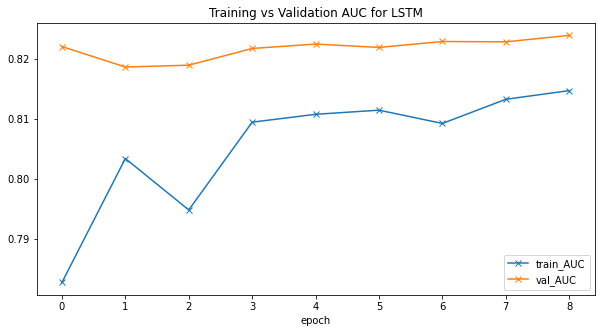

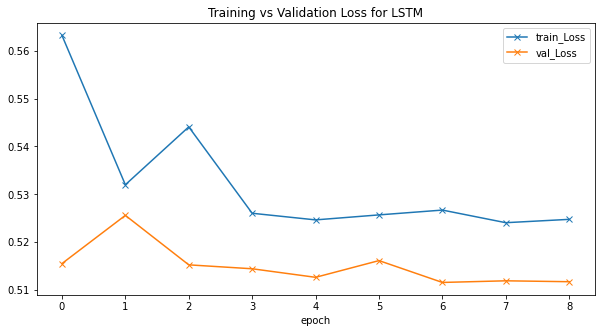

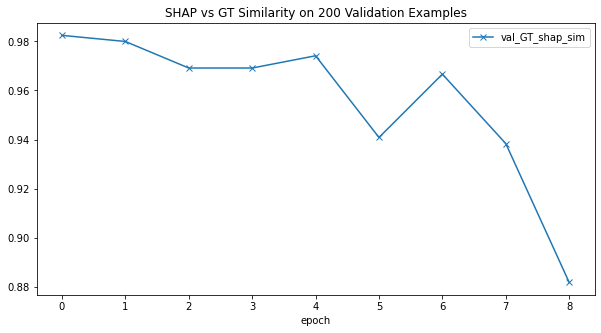

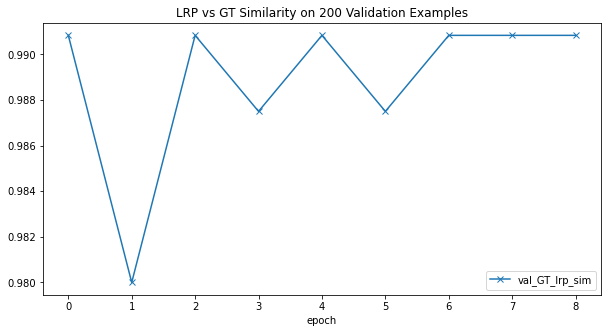

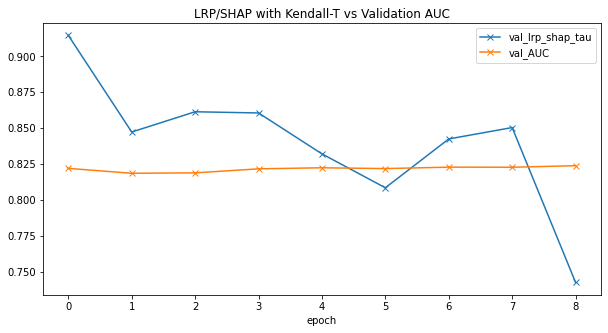

In [22]:
figsize = (10, 5)
df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["train_AUC", "val_AUC"],
    kind="line",
    marker="x",
)
plt.title("Training vs Validation AUC for LSTM")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["train_Loss", "val_Loss"],
    kind="line",
    marker="x",
)
plt.title("Training vs Validation Loss for LSTM")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_GT_shap_sim"],
    kind="line",
    marker="x",
)
plt.title(
    f"SHAP vs GT Similarity on {MODEL_PARAMS['num_eval_val']} Validation Examples"
)

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_GT_lrp_sim"],
    kind="line",
    marker="x",
)
plt.title(f"LRP vs GT Similarity on {MODEL_PARAMS['num_eval_val']} Validation Examples")

df_results.reset_index().plot(
    figsize=figsize,
    x="epoch",
    y=["val_lrp_shap_tau", "val_AUC"],
    kind="line",
    marker="x",
)
plt.title("LRP/SHAP with Kendall-T vs Validation AUC")

plt.show()

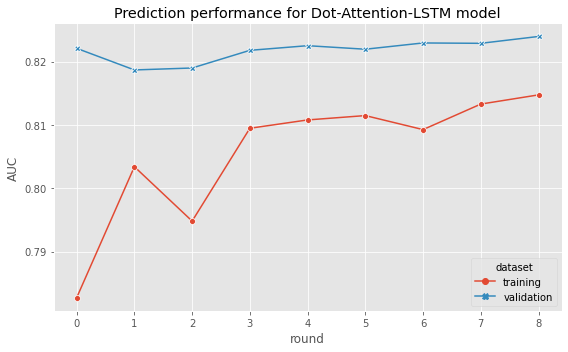

In [23]:
plt.style.use("ggplot")
train_df = imp_utils.ret_label_df(df_results.reset_index(), "train_AUC", "training")
val_df = imp_utils.ret_label_df(df_results.reset_index(), "val_AUC", "validation")
plot_df = pd.concat([train_df, val_df])
plt.figure(figsize=(8, 5))
ax = sns.lineplot(
    data=plot_df,
    x="epoch",
    y="AUC",
    hue="dataset",
    markers=True,
    dashes=False,
    style="dataset",
)
ax.set_title("Prediction performance for Dot-Attention-LSTM model")
ax.set_xlabel("round")
plt.tight_layout()
plt.show()

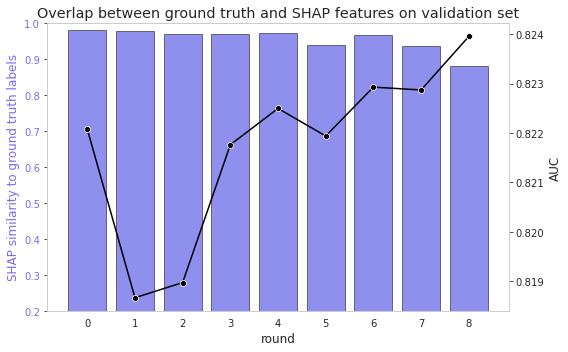

In [24]:
sns.set_style("whitegrid", {"axes.grid": False})
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_results.reset_index(),
    x="epoch",
    y="val_GT_shap_sim",
    color="blue",
    alpha=0.5,
    edgecolor="black",
    linewidth=1,
)
ax.set(ylim=(0.2, 1.0))
ax.set_xlabel("round")
ax.set_ylabel("SHAP similarity to ground truth labels", color="mediumslateblue")
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color("mediumslateblue")
ax2 = ax.twinx()
sns.lineplot(
    data=df_results.reset_index(),
    x="epoch",
    y="val_AUC",
    ax=ax2,
    color="black",
    marker="o",
)
ax2.set_ylabel("AUC")
ax.set_title("Overlap between ground truth and SHAP features on validation set")
ax.title.set_position([0.5, 1.05])
plt.tight_layout()
plt.show()

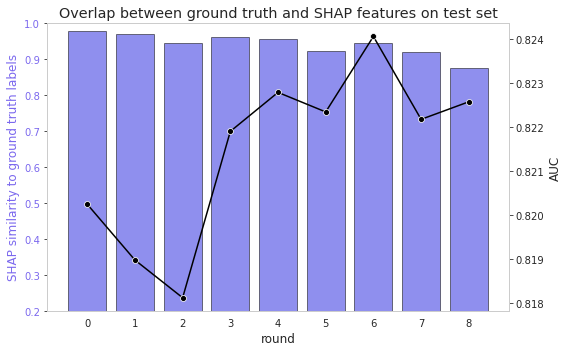

In [25]:
sns.set_style("whitegrid", {"axes.grid": False})
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_results.reset_index(),
    x="epoch",
    y="test_GT_shap_sim",
    color="blue",
    alpha=0.5,
    edgecolor="black",
    linewidth=1,
)
ax.set(ylim=(0.2, 1.0))
ax.set_xlabel("round")
ax.set_ylabel("SHAP similarity to ground truth labels", color="mediumslateblue")
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color("mediumslateblue")
ax2 = ax.twinx()
sns.lineplot(
    data=df_results.reset_index(),
    x="epoch",
    y="test_AUC",
    ax=ax2,
    color="black",
    marker="o",
)
ax2.set_ylabel("AUC")
ax.set_title("Overlap between ground truth and SHAP features on test set")
ax.title.set_position([0.5, 1.05])
plt.tight_layout()
plt.show()

## Visualize SHAP

In [26]:
df_results

,train_AUC,train_Loss,val_AUC,val_Loss,test_AUC,test_Loss,val_lrp_shap_tau,test_lrp_shap_tau,val_GT_lrp_sim,val_GT_shap_sim,val_GT_att_sim,test_GT_lrp_sim,test_GT_shap_sim,test_GT_att_sim,val_GT_self_att_sim,test_GT_self_att_sim
epoch,,,,,,,,,,,,,,,,
0,0.782700,0.563198,0.822079,0.515557,0.820246,0.516930,0.914574,0.913033,0.990833,0.982500,0.202500,0.980000,0.977500,0.203333,0.360833,0.375000
1,0.803390,0.532015,0.818667,0.525619,0.818981,0.524803,0.847367,0.843741,0.980000,0.980000,0.048333,0.966667,0.970000,0.060000,0.366667,0.376667
2,0.794803,0.544092,0.818974,0.515292,0.818126,0.516855,0.861446,0.864680,0.990833,0.969167,0.200000,0.980000,0.945833,0.216667,0.350833,0.390000
3,0.809457,0.526060,0.821763,0.514472,0.821899,0.515829,0.860610,0.868749,0.987500,0.969167,0.176667,0.976667,0.960833,0.180833,0.378333,0.378333
4,0.810774,0.524676,0.822498,0.512688,0.822783,0.513377,0.832158,0.839896,0.990833,0.974167,0.152500,0.980000,0.956667,0.153333,0.350000,0.400000
5,0.811461,0.525719,0.821940,0.516177,0.822340,0.519320,0.808593,0.809940,0.987500,0.940833,0.100000,0.976667,0.922500,0.100833,0.358333,0.367500
6,0.809248,0.526725,0.822929,0.511618,0.824051,0.512881,0.842549,0.849251,0.990833,0.966667,0.092500,0.980000,0.945000,0.104167,0.359167,0.370000
7,0.813277,0.524090,0.822871,0.511960,0.822171,0.515036,0.850454,0.841213,0.990833,0.938333,0.131667,0.980000,0.921667,0.136667,0.358333,0.380833
8,0.814730,0.524790,0.823954,0.511771,0.822570,0.515063,0.742766,0.731511,0.990833,0.881667,0.122500,0.980000,0.875833,0.129167,0.358333,0.366667


In [27]:
# Select the best epoch first
best_epoch = imp_utils.get_best_epoch(df_results, by="val_AUC")
best_epoch

8

In [28]:
val_scores = valid_results[best_epoch]
all_features = []
lrp_all_scores = []
shap_all_scores = []
attn_all_scores = []
self_attn_all_scores = []
for pat_id, scores in val_scores.items():
    shap_all_scores.append(
        valid_results[best_epoch][pat_id]["imp"]["shap_scores"].tolist()
    )
    lrp_all_scores.append(
        valid_results[best_epoch][pat_id]["imp"]["lrp_scores"].tolist()
    )
    attn_all_scores.append(
        valid_results[best_epoch][pat_id]["imp"]["att_weights"].tolist()
    )
    all_features.append(valid_results[best_epoch][pat_id]["imp"]["token"].tolist())

    if ADD_SELF_ATTENTION:
        self_attn_all_scores.append(
            valid_results[best_epoch][pat_id]["imp"]["self_att_weights"].tolist()
        )

shap_global_scores = imp_utils.get_global_feature_importance(
    all_features, shap_all_scores, absolute=True
)
lrp_global_scores = imp_utils.get_global_feature_importance(
    all_features, lrp_all_scores, absolute=True
)

att_global_scores = imp_utils.get_global_feature_importance(
    all_features, attn_all_scores, absolute=True
)

if ADD_SELF_ATTENTION:
    self_att_global_scores = imp_utils.get_global_feature_importance(
        all_features, self_attn_all_scores, absolute=True
    )

In [29]:
rows = []
for token in shap_global_scores.keys():
    token_scores = [
        token,
        shap_global_scores[token],
        lrp_global_scores[token],
        att_global_scores[token],
    ]
    if ADD_SELF_ATTENTION:
        token_scores.append(self_att_global_scores[token])

    rows.append(token_scores)

In [30]:
als_df = pd.DataFrame(rows)
if not ADD_SELF_ATTENTION:
    als_df.columns = ["features", "shap_scores", "lrp_scores", "attention_weights"]
else:
    als_df.columns = [
        "features",
        "shap_scores",
        "lrp_scores",
        "attention_weights",
        "self_attention_weights",
    ]

als_df.head()

,features,shap_scores,lrp_scores,attention_weights,self_attention_weights
0,hay_fever_N,0.002344,0.023881,0.060937,0.033408
1,myopia_N,0.002855,0.032589,0.060400,0.033383
2,peanut_allergy_N,0.003655,0.033960,0.063002,0.033362
3,ankle_sprain_N,0.003852,0.040092,0.067876,0.033483
4,dental_exam_N,0.004428,0.031224,0.068029,0.033475


### Distribution of similarities

In [31]:
rows = []
for pid in valid_results[best_epoch].keys():
    imp_df = valid_results[best_epoch][pid]["imp"]

    pid_data = valid_results[best_epoch][pid]
    row = [pid, pid_data["lrp_sim"], pid_data["shap_sim"], pid_data["att_sim"]]
    if ADD_SELF_ATTENTION:
        row.append(pid_data["self_att_sim"])

    rows.append(row)

In [32]:
sims = pd.DataFrame(rows)
if not ADD_SELF_ATTENTION:
    sims.columns = ["patient_id", "lrp_sim", "shap_sim", "att_sim"]
else:
    sims.columns = ["patient_id", "lrp_sim", "shap_sim", "att_sim", "self_att_sim"]
sims.head()

,patient_id,lrp_sim,shap_sim,att_sim,self_att_sim
0,7KBT9V548D,1.000000,1.000000,0.333333,0.333333
1,0OQFIO3Y6E,1.000000,0.666667,0.333333,0.666667
2,9NDFL3D4IW,1.000000,1.000000,0.000000,0.500000
3,1V8V7FON8P,1.000000,1.000000,0.000000,1.000000
4,G0LYJ1CGNS,0.666667,0.666667,0.000000,0.000000


In [33]:
sims.describe()

,lrp_sim,shap_sim,att_sim,self_att_sim
count,200.000000,200.000000,200.000000,200.000000
mean,0.990833,0.881667,0.122500,0.358333
std,0.058354,0.212395,0.217517,0.279462
min,0.500000,0.000000,0.000000,0.000000
25%,1.000000,0.666667,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.333333
75%,1.000000,1.000000,0.333333,0.500000
max,1.000000,1.000000,1.000000,1.000000


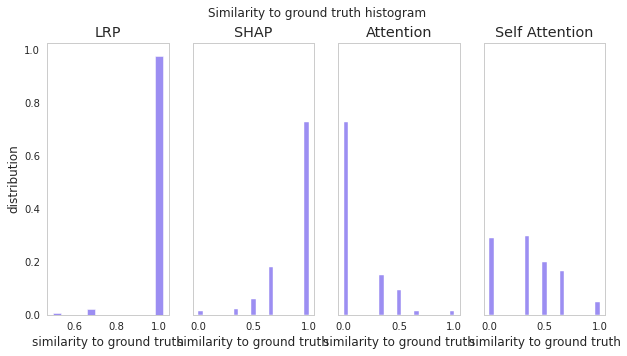

In [34]:
if ADD_SELF_ATTENTION:
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True, figsize=(10, 5))
else:
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(10, 5))

sns.histplot(
    sims.lrp_sim, ax=ax1, binwidth=0.04, color="mediumslateblue", stat="probability"
)
ax1.set_xlabel("similarity to ground truth")
ax1.set_title("LRP")
ax1.set_ylabel("distribution")

sns.histplot(
    sims.shap_sim, ax=ax2, binwidth=0.04, color="mediumslateblue", stat="probability"
)
ax2.set_xlabel("similarity to ground truth")
ax2.set_title("SHAP")

sns.histplot(
    sims.att_sim, ax=ax3, binwidth=0.04, color="mediumslateblue", stat="probability"
)
ax3.set_xlabel("similarity to ground truth")
ax3.set_title("Attention")

if ADD_SELF_ATTENTION:
    sns.histplot(
        sims.self_att_sim,
        ax=ax4,
        binwidth=0.04,
        color="mediumslateblue",
        stat="probability",
    )
    ax4.set_xlabel("similarity to ground truth")
    ax4.set_title("Self Attention")

plt.suptitle("Similarity to ground truth histogram")
plt.show()

### Global Feature Importance

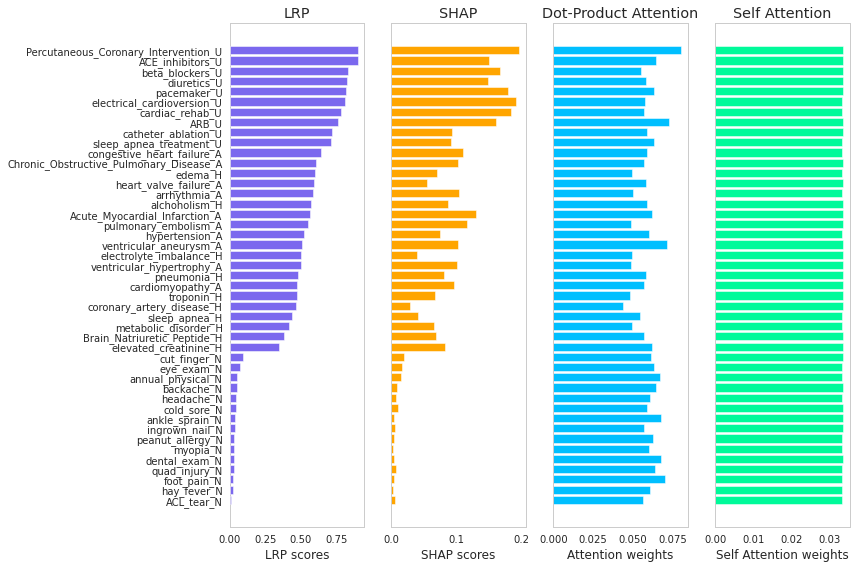

In [35]:
als_df.sort_values("lrp_scores", ascending=True, inplace=True)

if ADD_SELF_ATTENTION:
    fig = plt.figure(figsize=(12, 8))
    axes = fig.subplots(ncols=4, sharey=True)
else:
    fig = plt.figure(figsize=(10, 8))
    axes = fig.subplots(ncols=3, sharey=True)

axes[0].barh(
    als_df.features,
    als_df.lrp_scores,
    color="mediumslateblue",
    align="center",
    zorder=10,
)
axes[0].set(title="LRP", xlabel="LRP scores")

axes[1].barh(als_df.features, als_df.shap_scores, color="orange", align="center")
axes[1].set(title="SHAP", xlabel="SHAP scores")

axes[2].barh(
    als_df.features, als_df.attention_weights, color="deepskyblue", align="center"
)
axes[2].set(title="Dot-Product Attention", xlabel="Attention weights")

if ADD_SELF_ATTENTION:
    axes[3].barh(
        als_df.features,
        als_df.self_attention_weights,
        color="mediumspringgreen",
        align="center",
    )
    axes[3].set(title="Self Attention", xlabel="Self Attention weights")

fig.subplots_adjust(wspace=0.09)
plt.tight_layout()
plt.show()

### Global For each Explainability Method

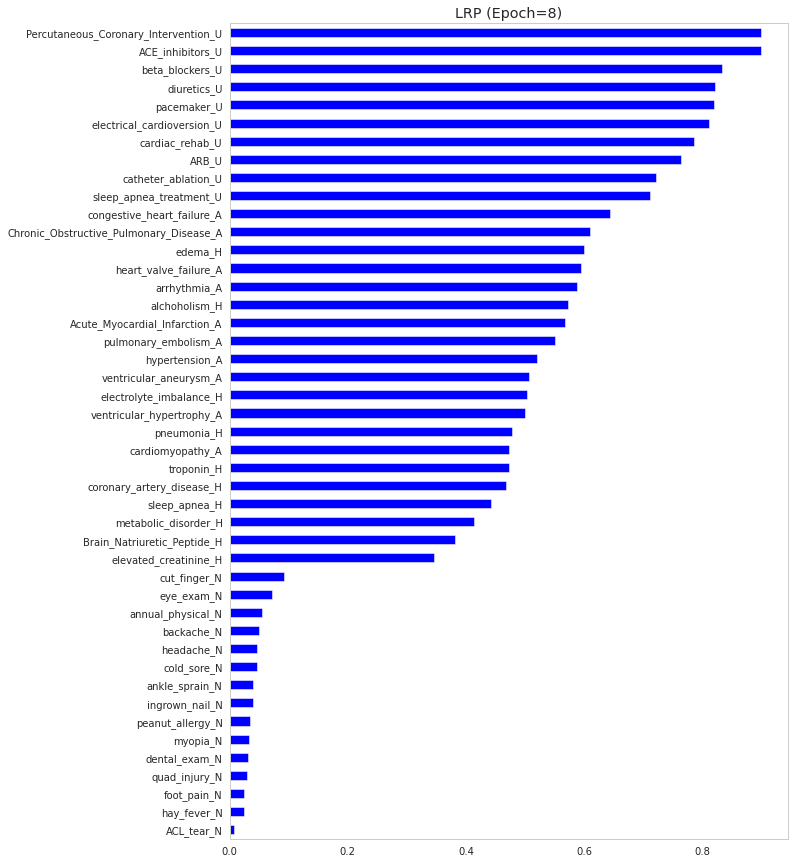

In [36]:
all_features = []
all_scores = []
for pat_id, scores in val_scores.items():
    all_scores.append(valid_results[best_epoch][pat_id]["imp"]["lrp_scores"].tolist())
    all_features.append(valid_results[best_epoch][pat_id]["imp"]["token"].tolist())
global_scores = imp_utils.get_global_feature_importance(
    all_features, all_scores, absolute=True
)
title = f"LRP (Epoch={best_epoch})"
imp_utils.plot_global_feature_importance(global_scores, title=title)

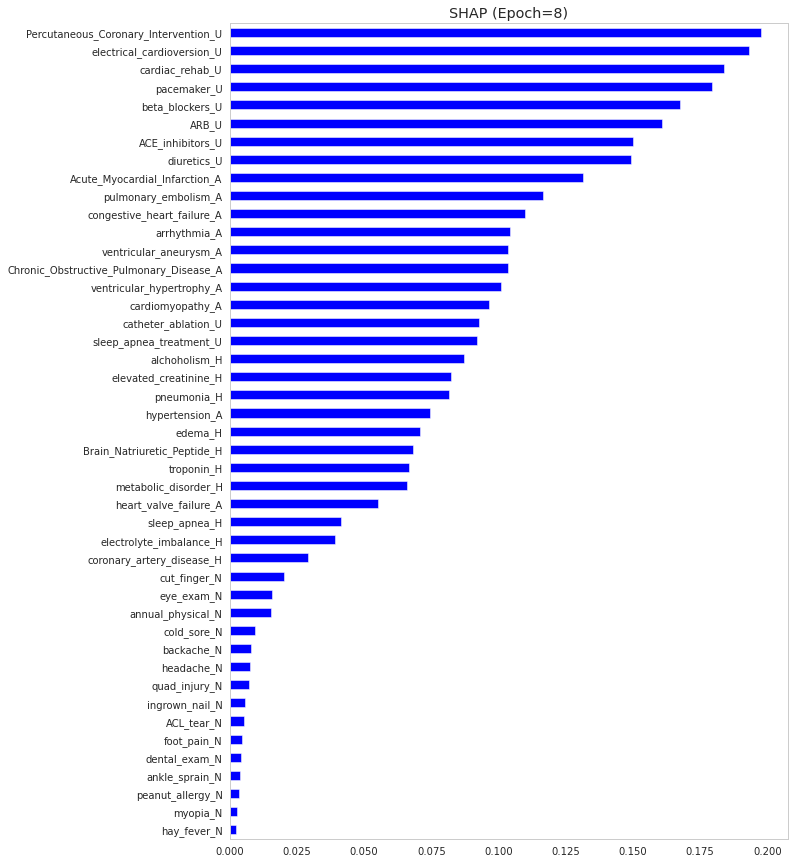

In [37]:
all_features = []
all_scores = []
for pat_id, scores in val_scores.items():
    all_scores.append(valid_results[best_epoch][pat_id]["imp"]["shap_scores"].tolist())
    all_features.append(valid_results[best_epoch][pat_id]["imp"]["token"].tolist())
    # print(valid_results[best_epoch][pat_id]["imp"]["token"])
global_scores = imp_utils.get_global_feature_importance(
    all_features, all_scores, absolute=True
)
title = f"SHAP (Epoch={best_epoch})"
imp_utils.plot_global_feature_importance(global_scores, title=title)

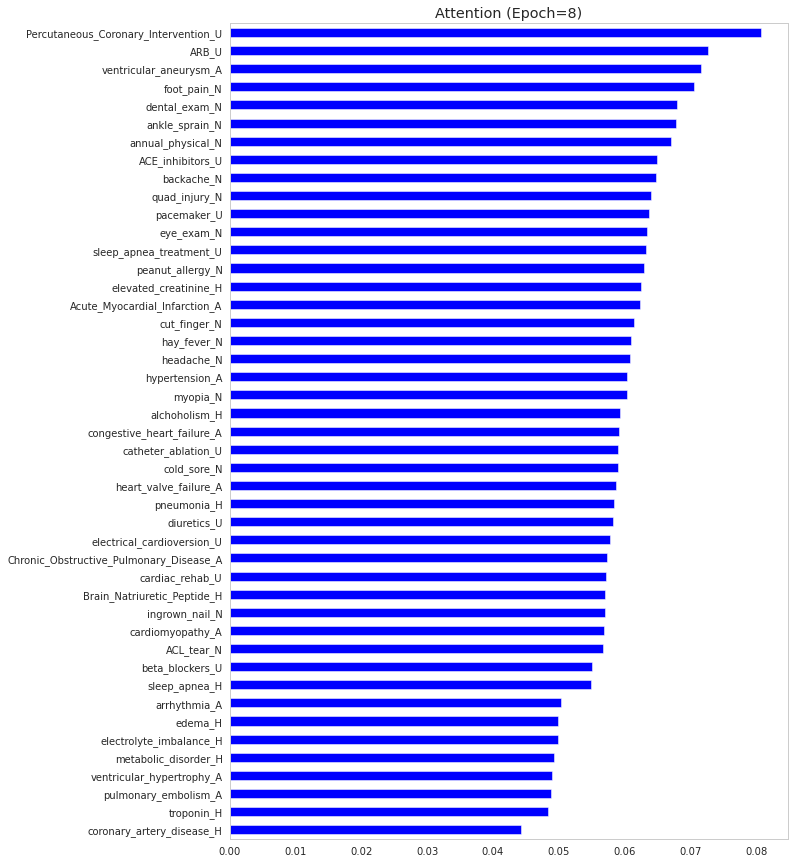

In [38]:
all_features = []
all_scores = []
for pat_id, scores in val_scores.items():
    all_scores.append(valid_results[best_epoch][pat_id]["imp"]["att_weights"].tolist())
    all_features.append(valid_results[best_epoch][pat_id]["imp"]["token"].tolist())
global_scores = imp_utils.get_global_feature_importance(
    all_features, all_scores, absolute=True
)
title = f"Attention (Epoch={best_epoch})"
imp_utils.plot_global_feature_importance(global_scores, title=title)

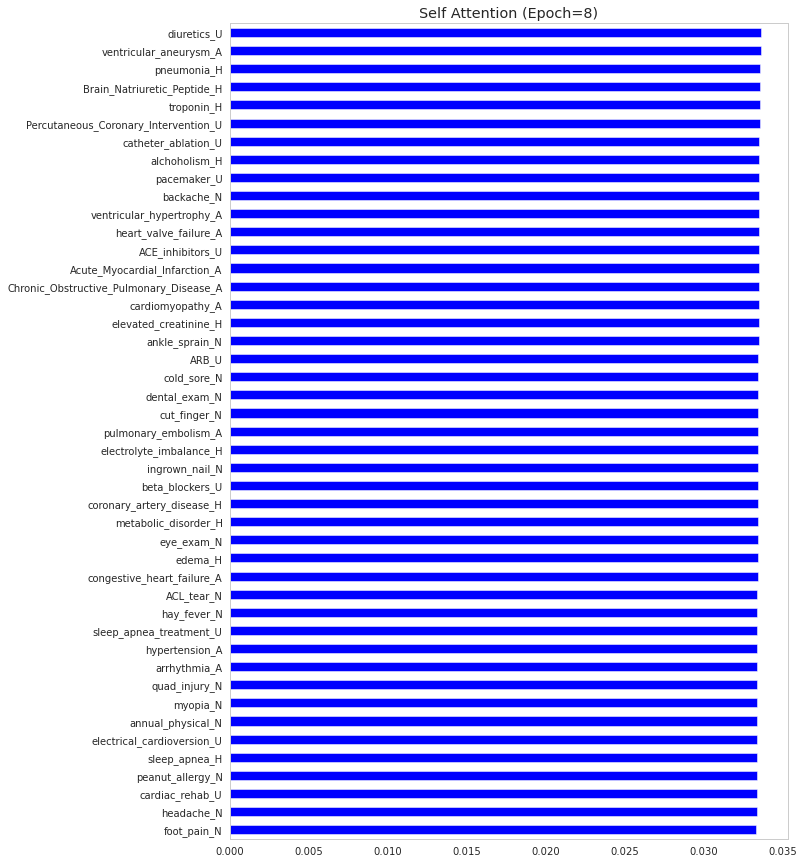

In [39]:
if ADD_SELF_ATTENTION:
    all_features = []
    all_scores = []
    for pat_id, scores in val_scores.items():
        all_scores.append(
            valid_results[best_epoch][pat_id]["imp"]["self_att_weights"].tolist()
        )
        all_features.append(valid_results[best_epoch][pat_id]["imp"]["token"].tolist())
    global_scores = imp_utils.get_global_feature_importance(
        all_features, all_scores, absolute=True
    )
    title = f"Self Attention (Epoch={best_epoch})"
    imp_utils.plot_global_feature_importance(global_scores, title=title)

## Local Feature Importance (Per-Observation)

In [40]:
example_results = {}
for pat_id in SELECTED_PATIENTS:
    example_results[pat_id] = {}
    for epoch in range(N_EPOCHS):
        if pat_id in test_results[epoch].keys():
            example_results[pat_id][epoch] = test_results[epoch][pat_id]
example_results.keys()

dict_keys(['VHCSIEPRI8', 'MIP0F9ZOUM', '79A4PHXNE6', 'CW780GL0AX'])

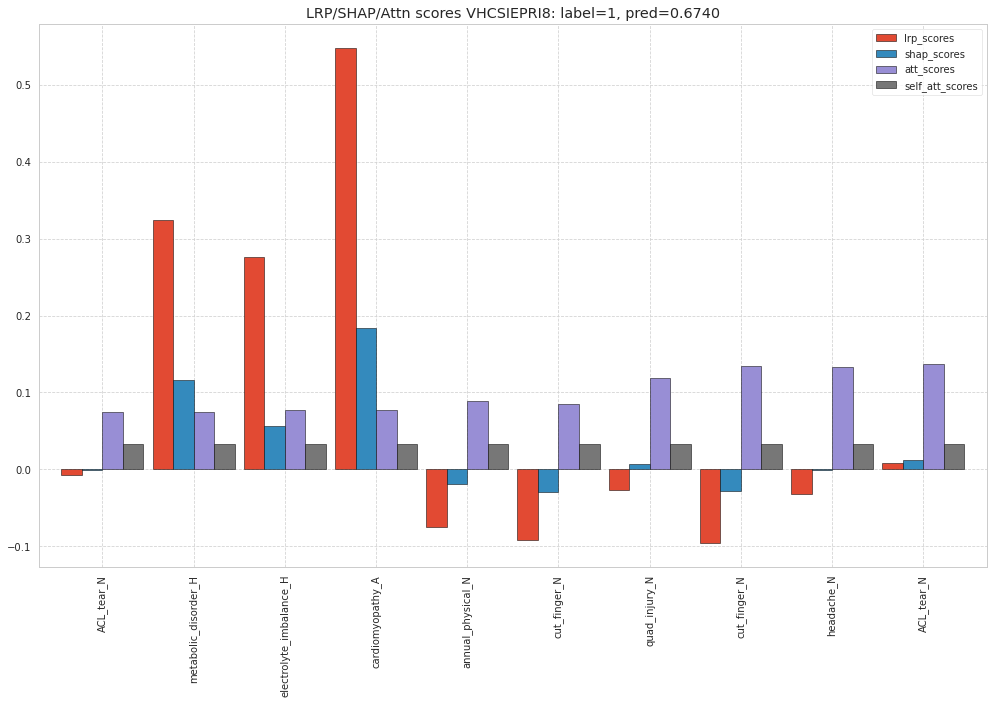

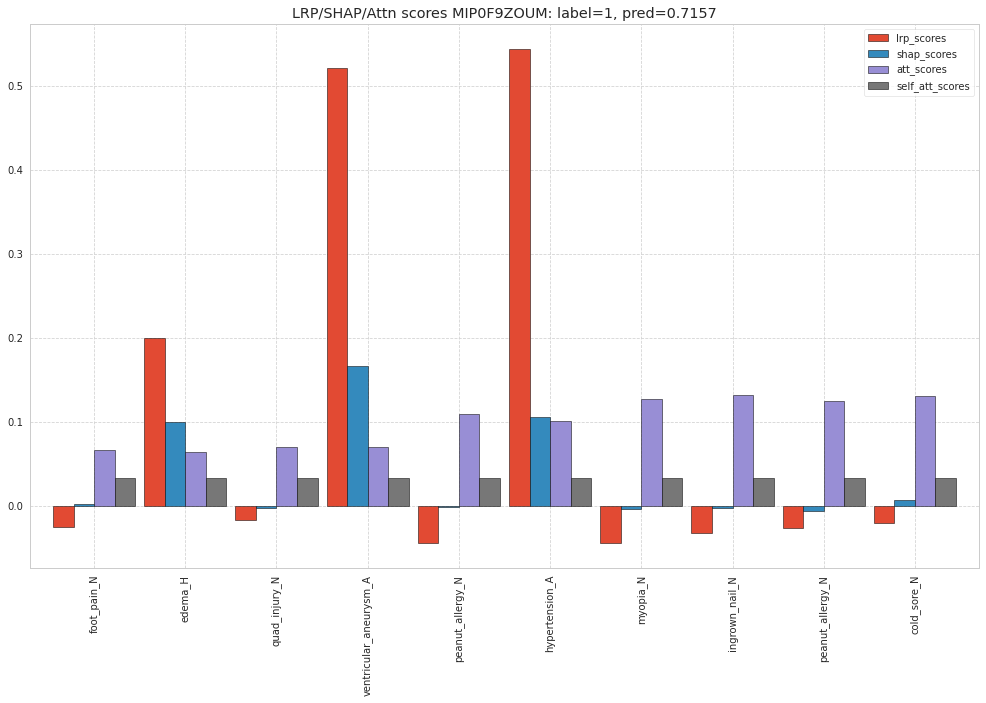

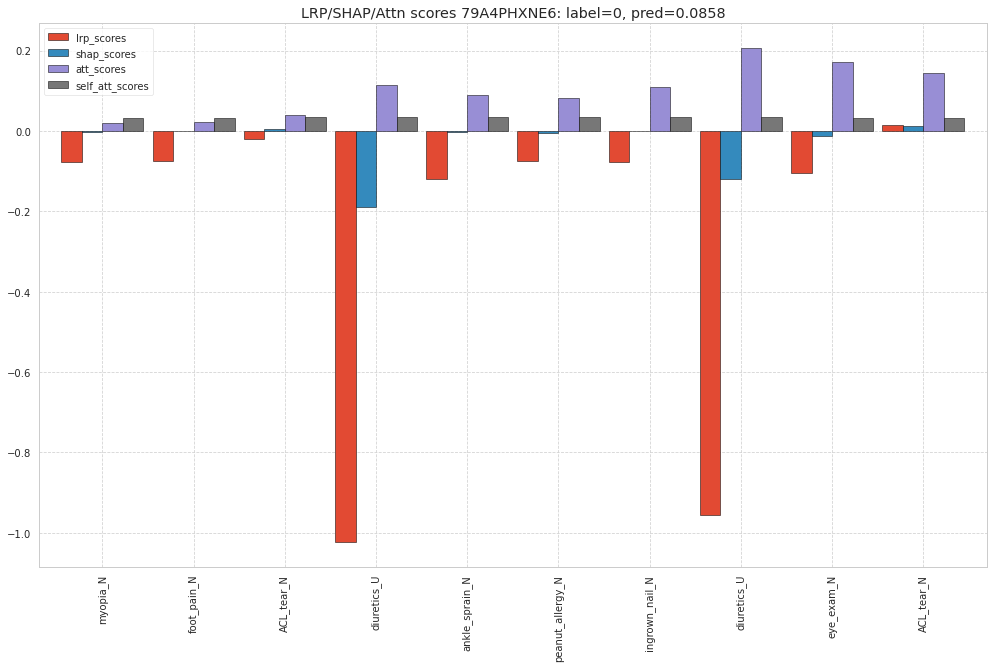

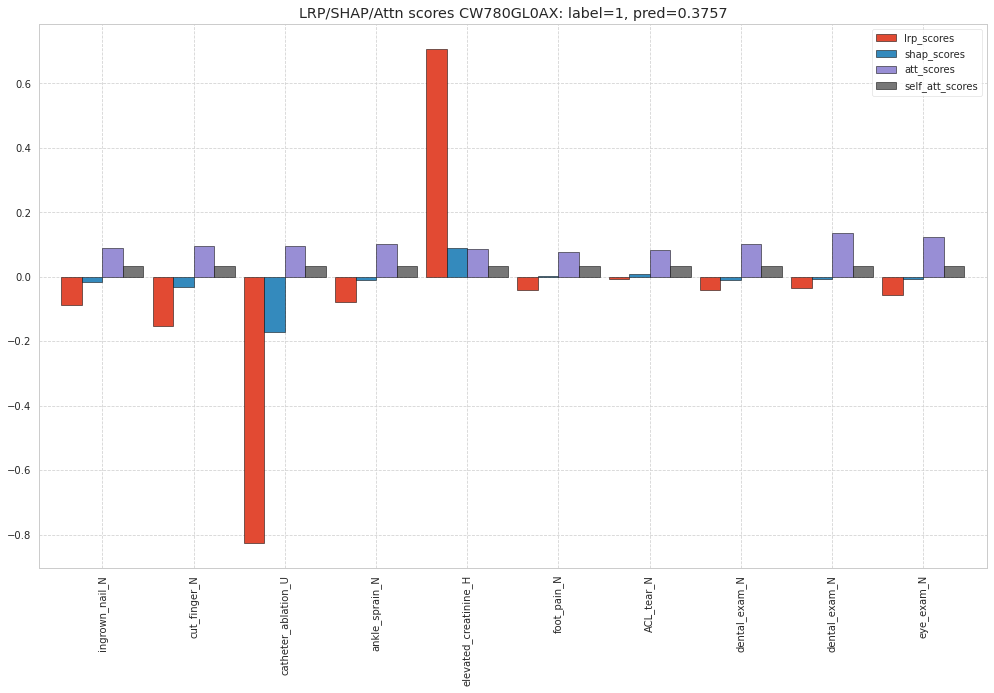

In [41]:
for uid in example_results.keys():
    df = pd.DataFrame()
    df["lrp_scores"] = example_results[uid][best_epoch]["imp"]["lrp_scores"]
    df["token"] = example_results[uid][best_epoch]["imp"]["token"]
    df["seq_idx"] = example_results[uid][best_epoch]["imp"]["seq_idx"]
    df["shap_scores"] = example_results[uid][best_epoch]["imp"]["shap_scores"]
    df["att_scores"] = example_results[uid][best_epoch]["imp"]["att_weights"]
    if ADD_SELF_ATTENTION:
        df["self_att_scores"] = example_results[uid][best_epoch]["imp"][
            "self_att_weights"
        ]
    # import pdb; pdb.set_trace()

    if not ADD_SELF_ATTENTION:
        df[["lrp_scores", "shap_scores", "att_scores"]].plot.bar(
            align="center", width=0.9, edgecolor="black", figsize=(17, 10)
        )
    else:
        df[["lrp_scores", "shap_scores", "att_scores", "self_att_scores"]].plot.bar(
            align="center", width=0.9, edgecolor="black", figsize=(17, 10)
        )
    plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90, zorder=1)

    lab = example_results[uid][epoch]["label"]
    pred = np.round(
        torch.sigmoid(torch.tensor(example_results[uid][best_epoch]["pred"])).numpy(), 4
    )

    plt.title(f"LRP/SHAP/Attn scores {uid}: label={lab[0]}, pred={pred:.4f}")
    plt.grid(color="lightgray", linestyle="--", zorder=3)

### Plot LSTM LRP & SHAP, LRP & SHAP & Attention Scores Separately

#### Plot SHAP

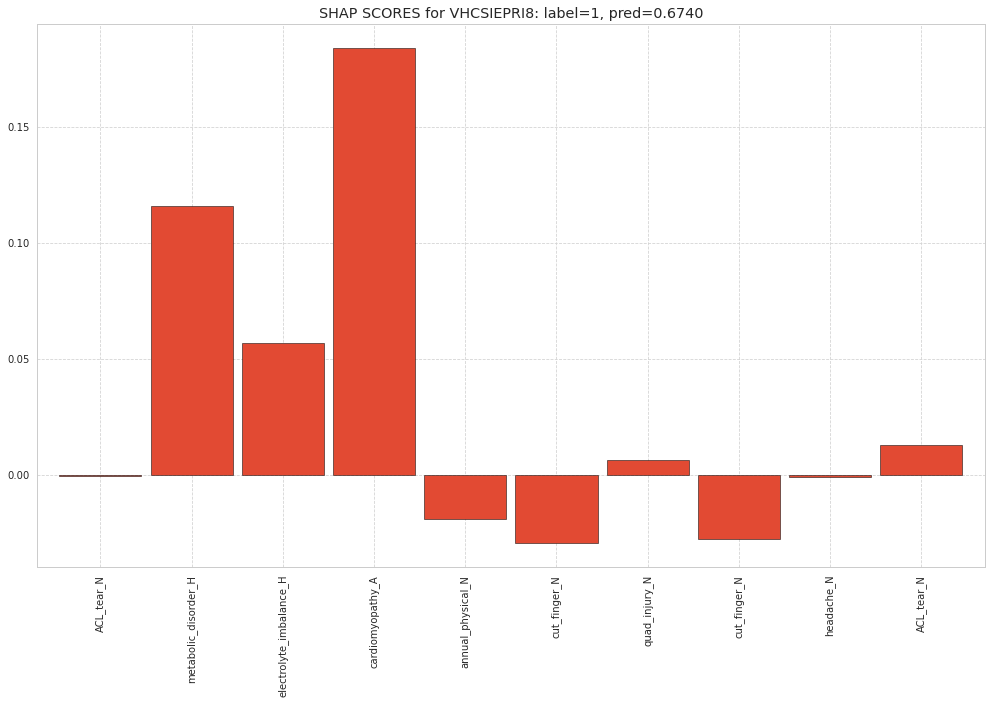

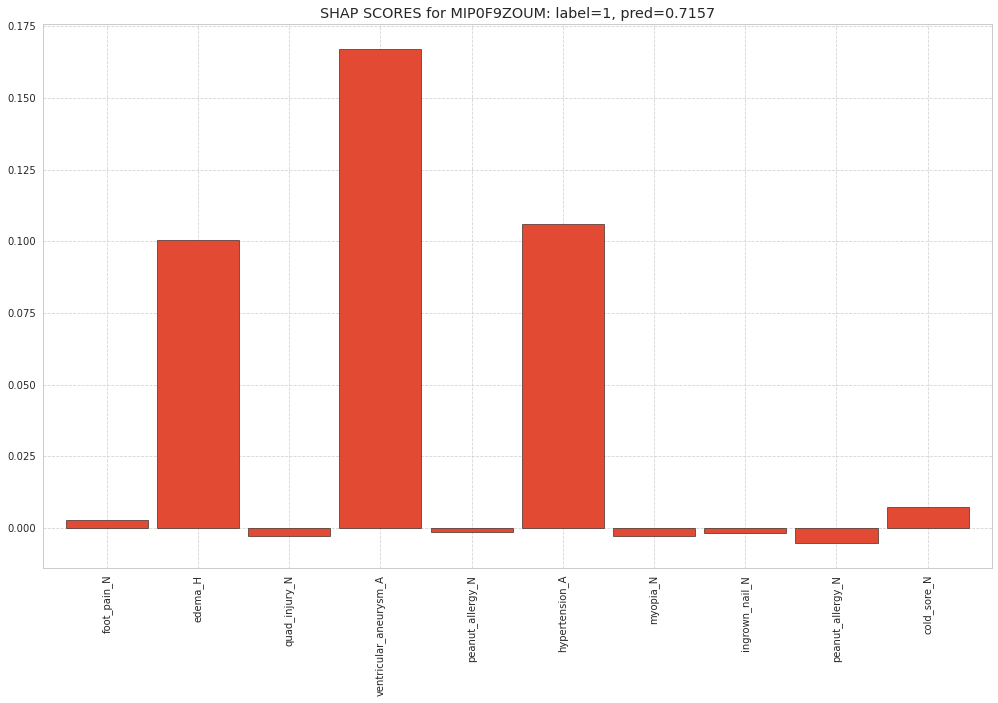

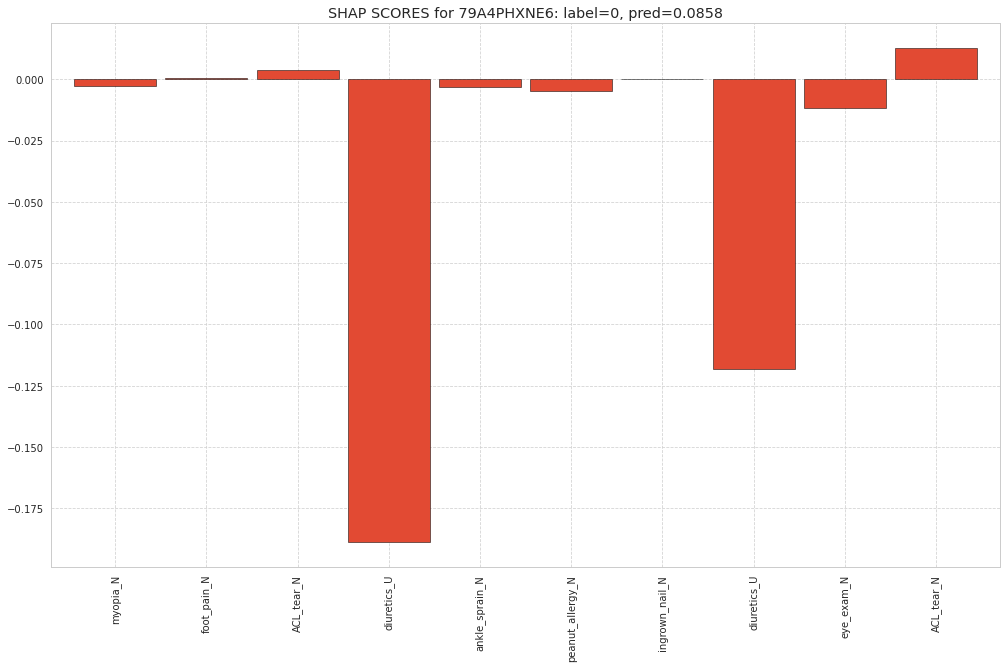

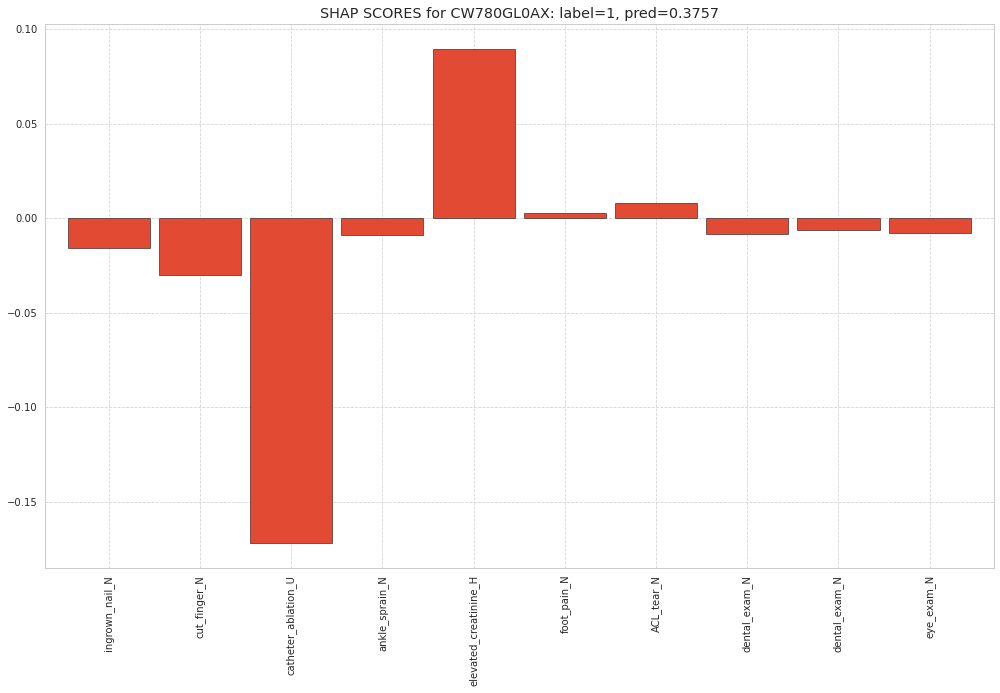

In [42]:
selected_epochs = [best_epoch]
for uid in example_results.keys():
    df = pd.DataFrame()
    for epoch in example_results[uid].keys():
        df[epoch] = example_results[uid][epoch]["imp"]["shap_scores"]
    df["token"] = example_results[uid][epoch]["imp"]["token"]
    df["seq_idx"] = example_results[uid][epoch]["imp"]["seq_idx"]

    # import pdb; pdb.set_trace()
    # df[example_results[uid].keys()].plot.bar(figsize=(17, 7))
    df[selected_epochs].plot.bar(
        align="center", width=0.9, edgecolor="black", figsize=(17, 10), legend=False
    )
    plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90)

    lab = example_results[uid][best_epoch]["label"]
    pred = np.round(
        torch.sigmoid(torch.tensor(example_results[uid][best_epoch]["pred"])).numpy(), 4
    )

    plt.title(f"SHAP SCORES for {uid}: label={lab[0]}, pred={pred:.4f}")
    plt.grid(color="lightgray", linestyle="--")

    plt.show()

#### Plot LRP

In [43]:
plt.rcParams["axes.axisbelow"] = True

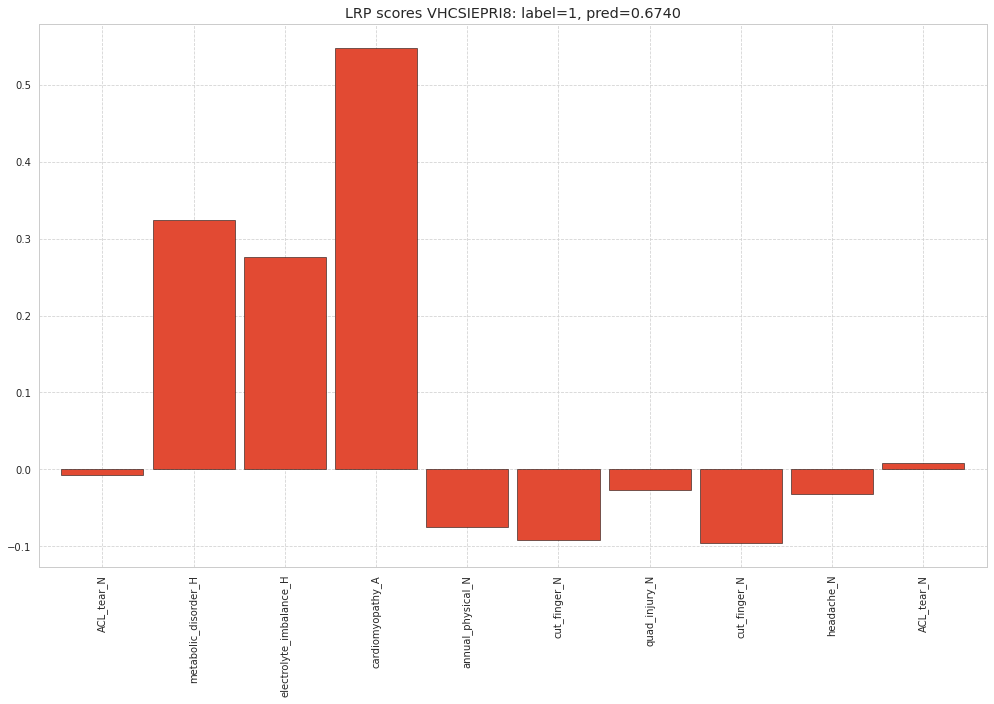

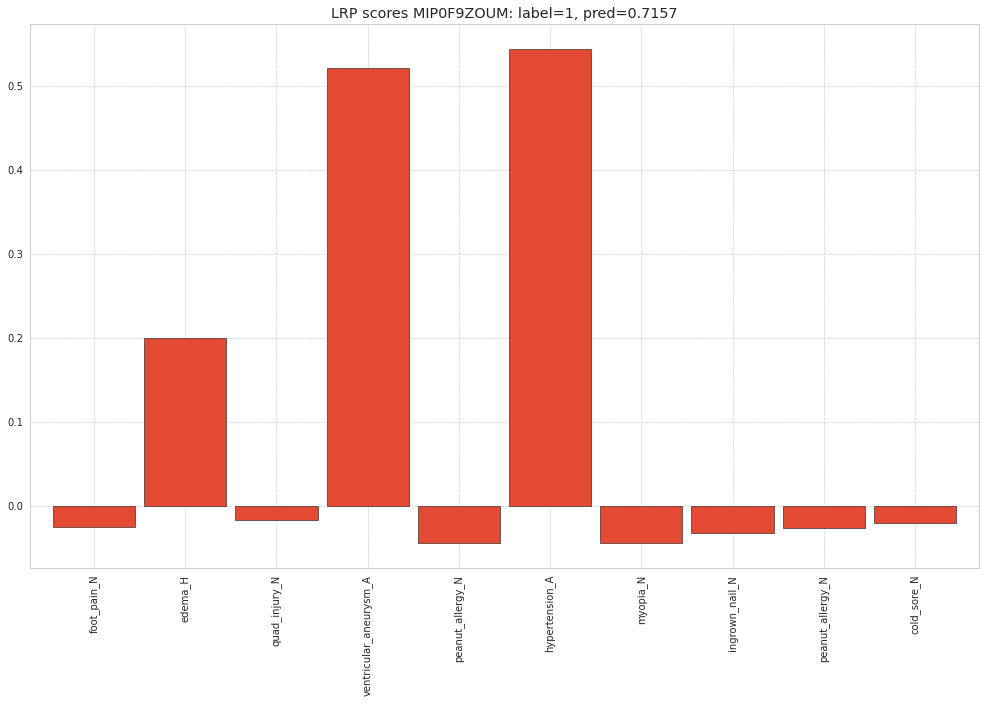

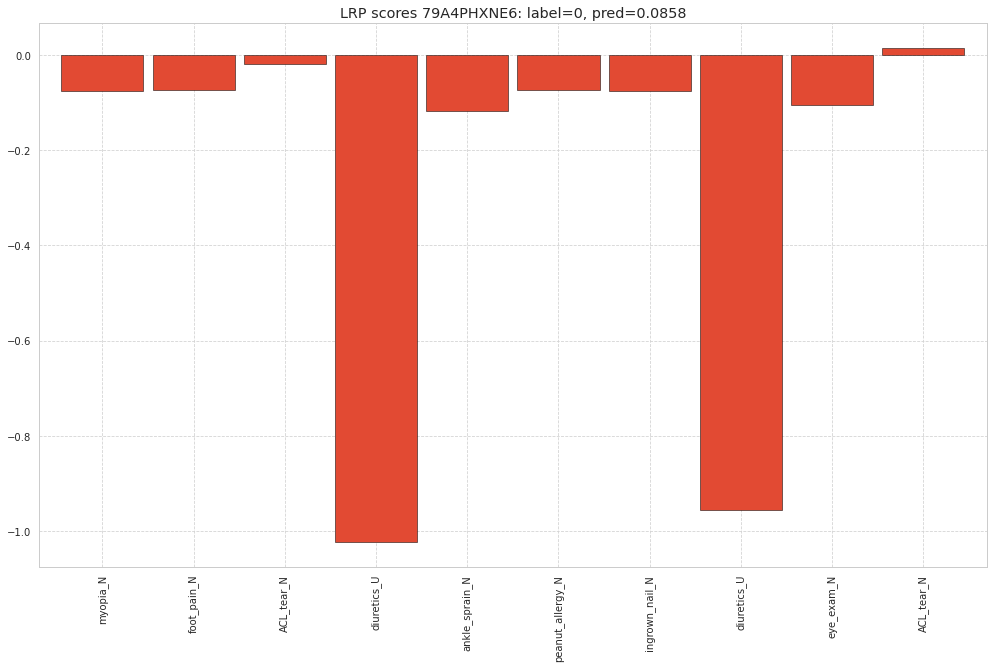

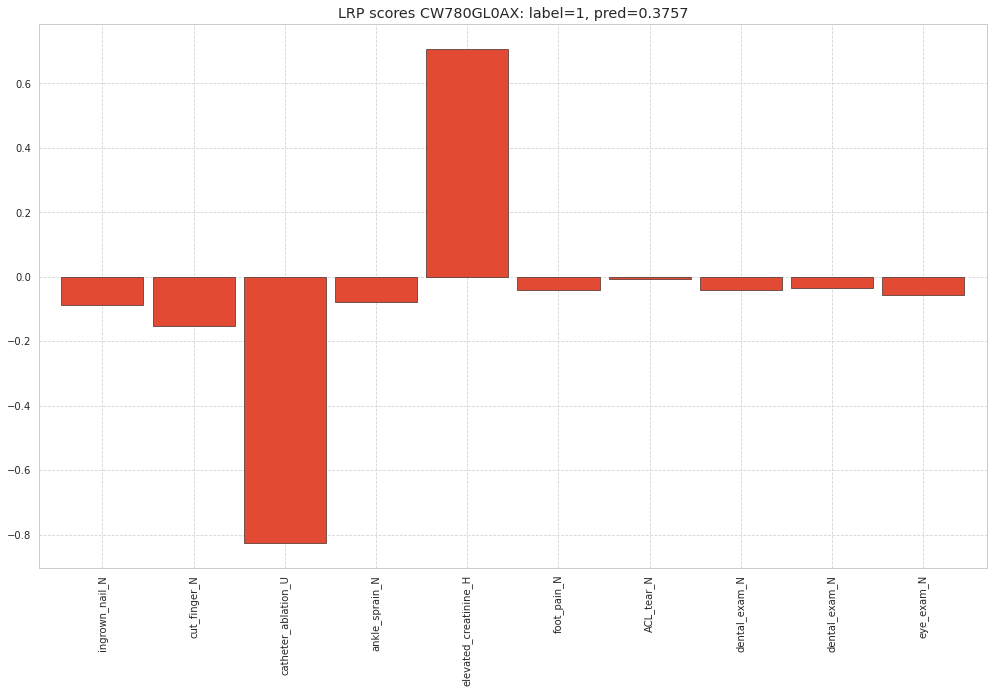

In [44]:
for uid in example_results.keys():
    df = pd.DataFrame()
    for epoch in example_results[uid].keys():
        df[epoch] = example_results[uid][epoch]["imp"]["lrp_scores"]
    df["token"] = example_results[uid][epoch]["imp"]["token"]
    df["seq_idx"] = example_results[uid][epoch]["imp"]["seq_idx"]

    # df[example_results[uid].keys()].plot.bar(figsize=(17, 7))
    df[selected_epochs].plot.bar(
        align="center", width=0.9, edgecolor="black", figsize=(17, 10), legend=False
    )
    plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90, zorder=1)

    lab = example_results[uid][best_epoch]["label"]
    pred = np.round(
        torch.sigmoid(torch.tensor(example_results[uid][best_epoch]["pred"])).numpy(), 4
    )

    plt.title(f"LRP scores {uid}: label={lab[0]}, pred={pred:.4f}")
    plt.grid(color="lightgray", linestyle="--", zorder=3)

### Plot Attention

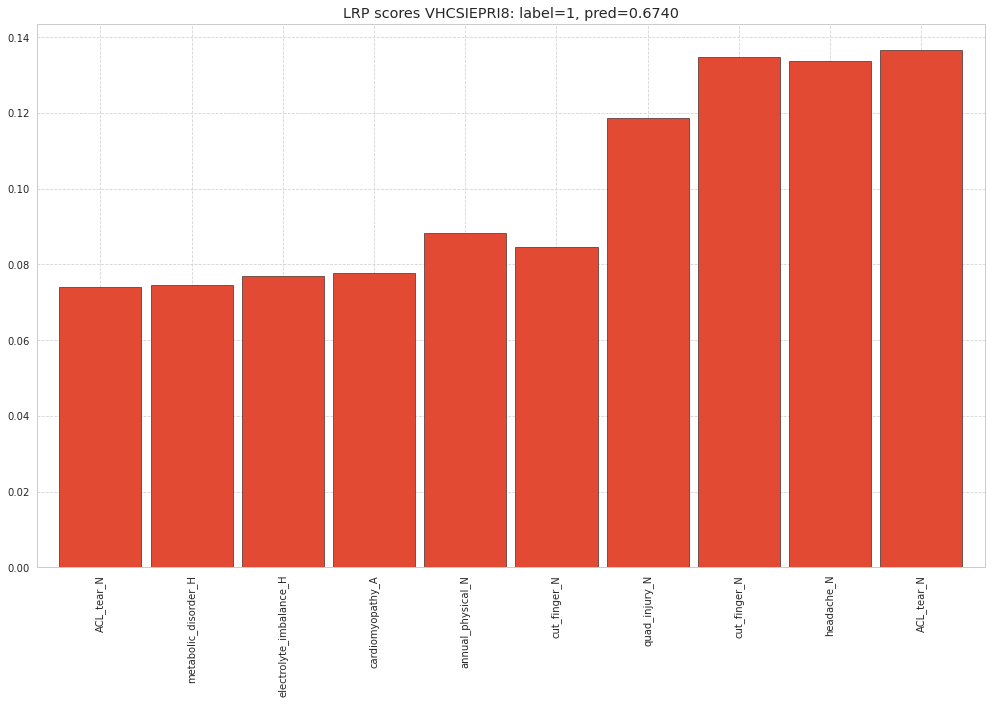

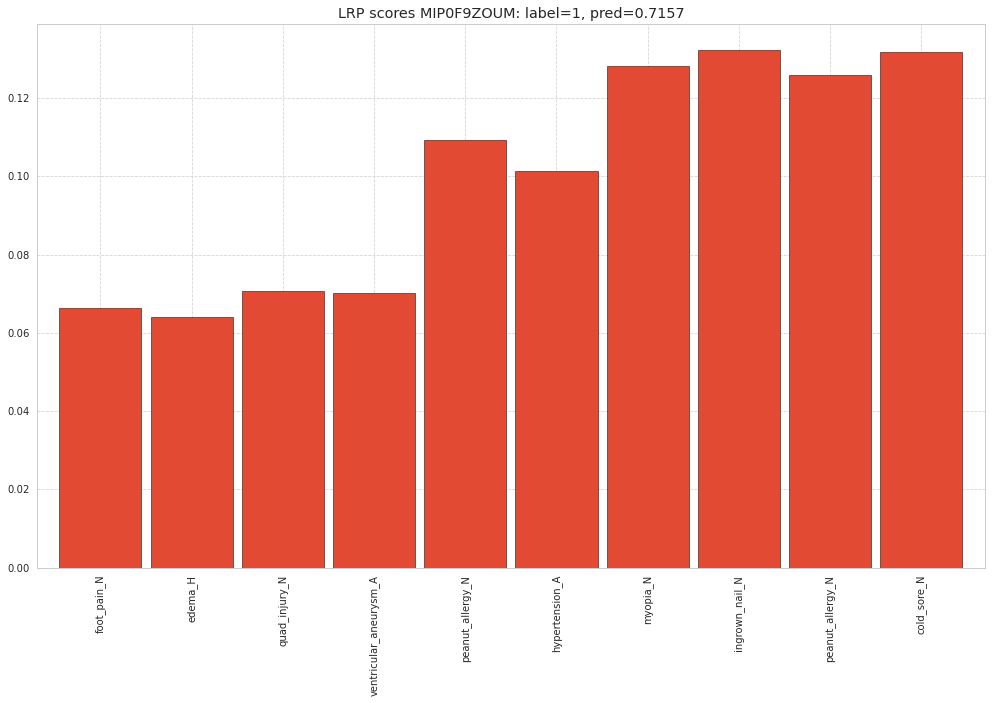

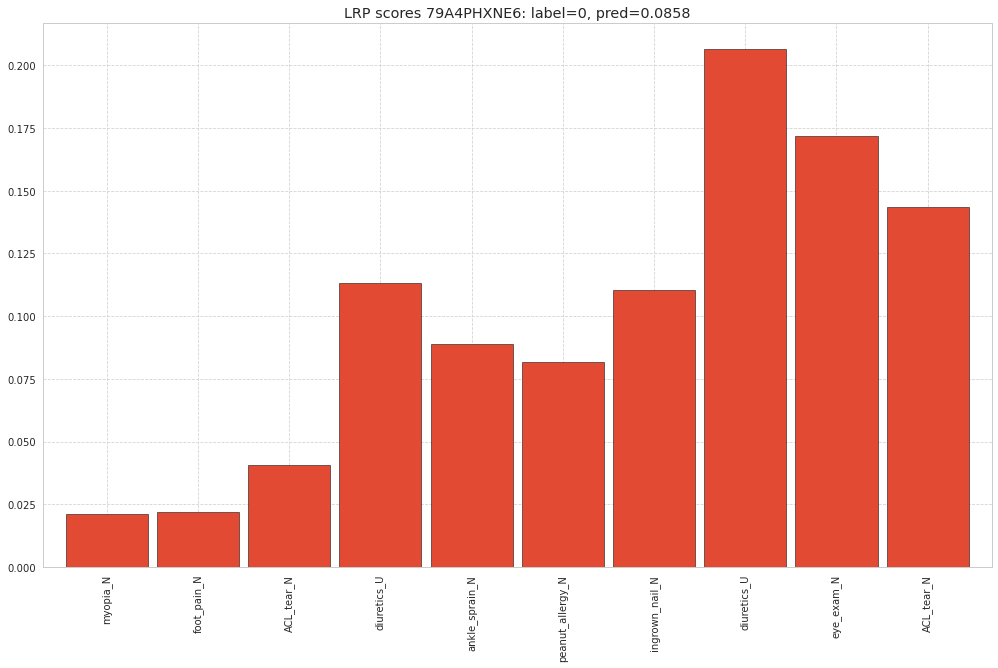

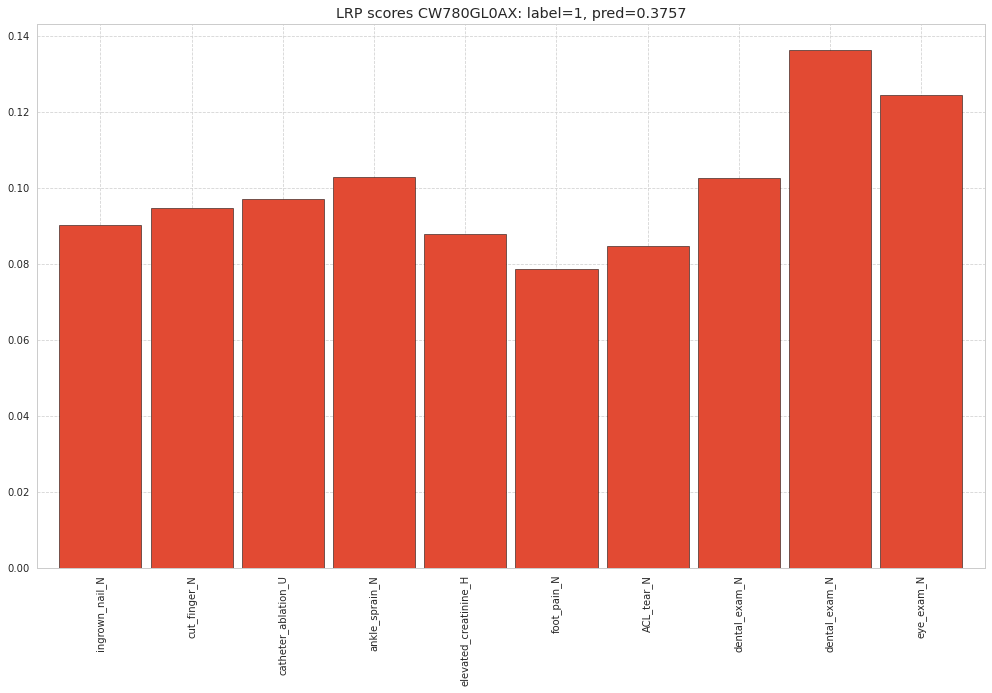

In [45]:
for uid in example_results.keys():
    df = pd.DataFrame()
    for epoch in example_results[uid].keys():
        df[epoch] = example_results[uid][epoch]["imp"]["att_weights"]
    df["token"] = example_results[uid][epoch]["imp"]["token"]
    df["seq_idx"] = example_results[uid][epoch]["imp"]["seq_idx"]

    df[selected_epochs].plot.bar(
        align="center", width=0.9, edgecolor="black", figsize=(17, 10), legend=False
    )
    plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90, zorder=1)

    lab = example_results[uid][best_epoch]["label"]
    pred = np.round(
        torch.sigmoid(torch.tensor(example_results[uid][best_epoch]["pred"])).numpy(), 4
    )

    plt.title(f"LRP scores {uid}: label={lab[0]}, pred={pred:.4f}")
    plt.grid(color="lightgray", linestyle="--", zorder=3)

## Plot Self Attention (if available)

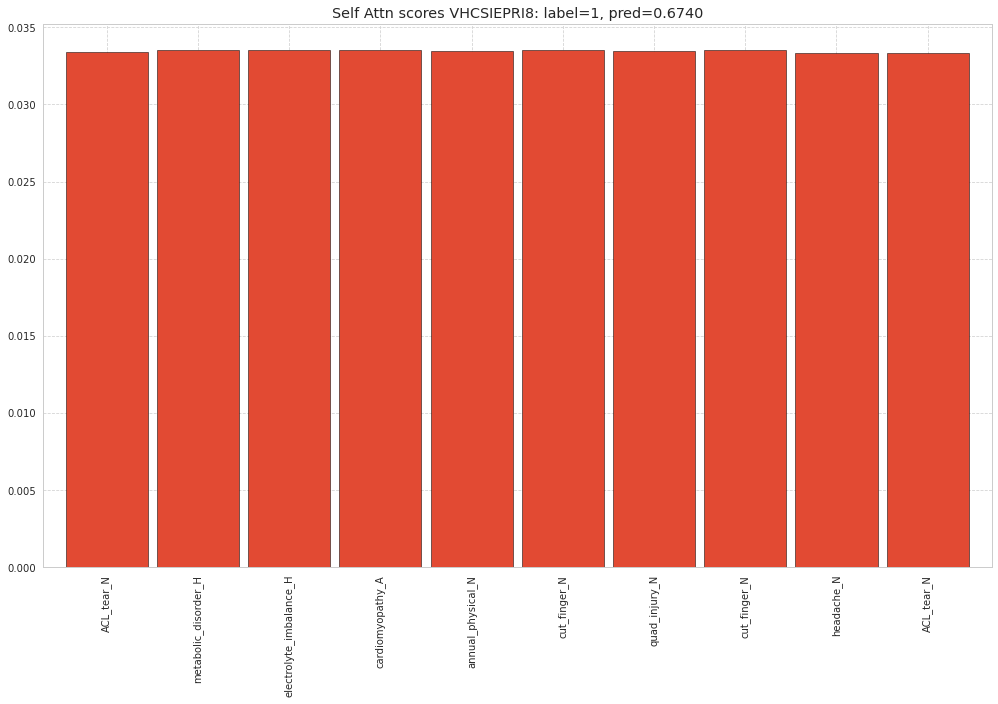

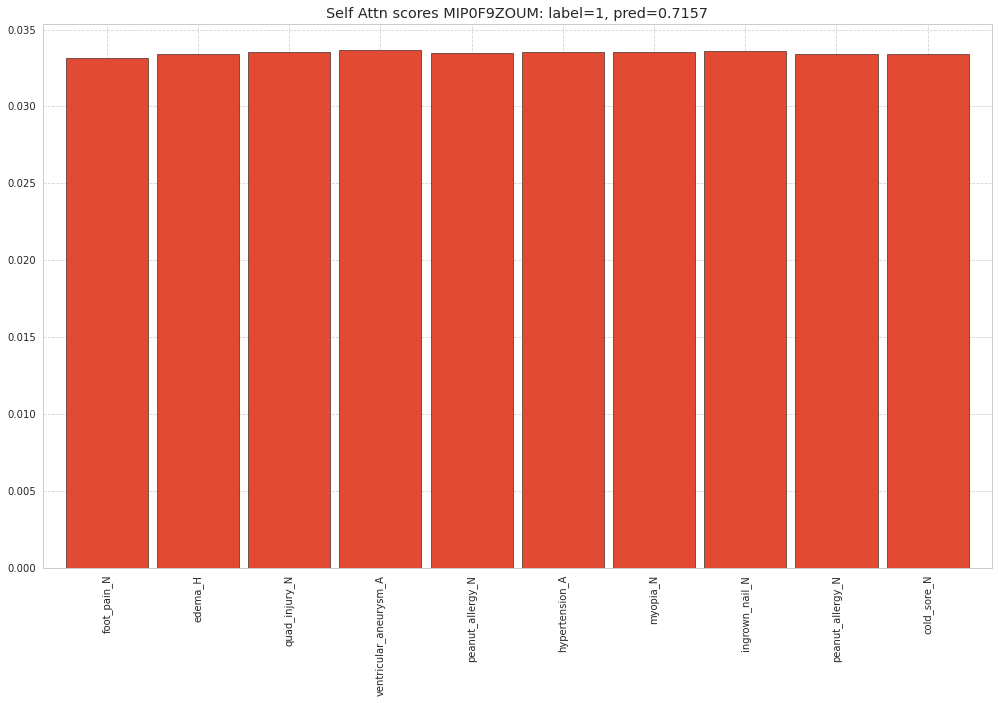

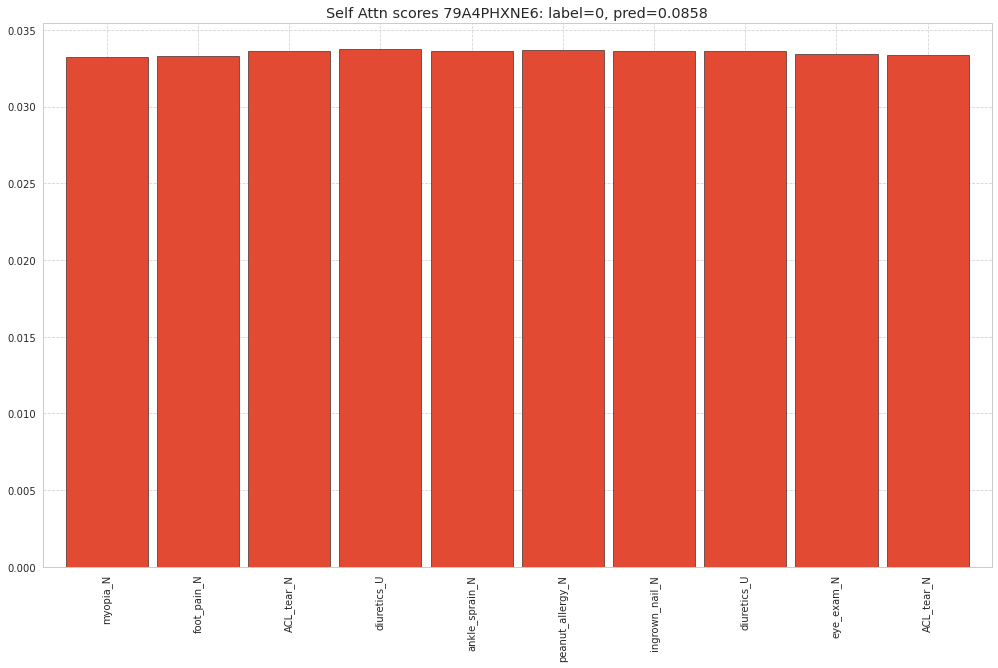

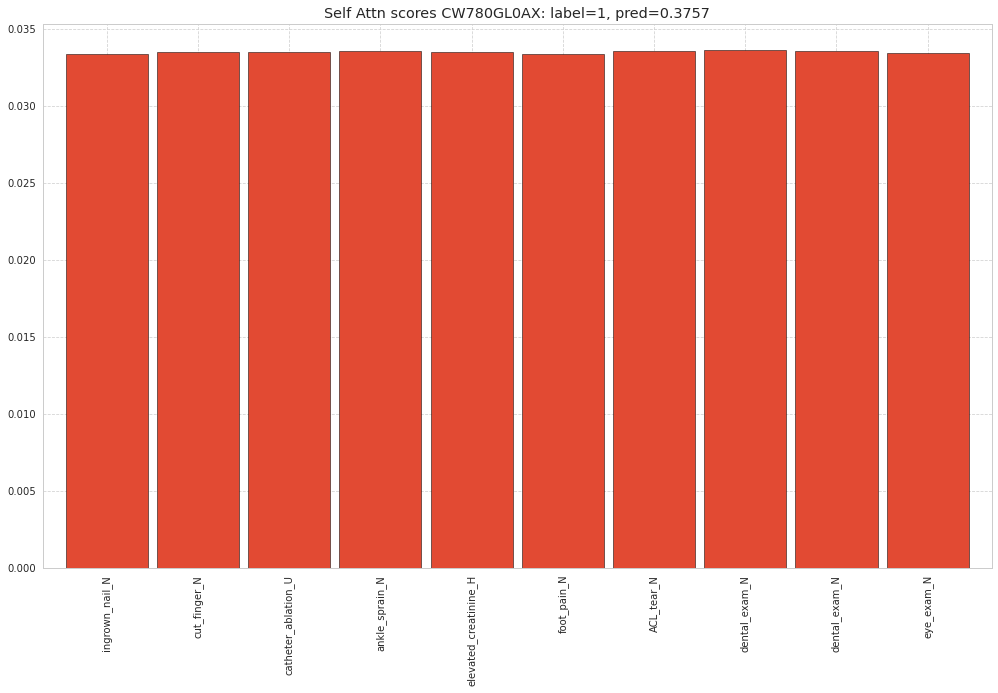

In [46]:
for uid in example_results.keys():
    df = pd.DataFrame()
    for epoch in example_results[uid].keys():
        df[epoch] = example_results[uid][epoch]["imp"]["self_att_weights"]
    df["token"] = example_results[uid][epoch]["imp"]["token"]
    df["seq_idx"] = example_results[uid][epoch]["imp"]["seq_idx"]

    df[selected_epochs].plot.bar(
        align="center", width=0.9, edgecolor="black", figsize=(17, 10), legend=False
    )
    plt.xticks(df["seq_idx"], df.token.values.tolist(), rotation=90, zorder=1)

    lab = example_results[uid][best_epoch]["label"]
    pred = np.round(
        torch.sigmoid(torch.tensor(example_results[uid][best_epoch]["pred"])).numpy(), 4
    )

    plt.title(f"Self Attn scores {uid}: label={lab[0]}, pred={pred:.4f}")
    plt.grid(color="lightgray", linestyle="--", zorder=3)